# CAR PRICE PREDICTION
# PART 1 - Business Understanding
## 1.1 - Problem Definition
One of the challenges people face with selling second hand cars is selling the cars at competitive prices. Typically people would filter sites like Autotrader to compare prices based on the age, mileage, body type, fuel type, etc of their cars. This sometimes can be painstaking for some people, who would rather have a means of inputting some details of their cars and readily getting a predicted price.

In this project, we will be looking at a dataset containing car sales posted on AutoTrader. The data have been obtained by web scraping AutoTrader, and then explored, processed, and prepared for predictive modelling.

## 1.2 - Project Goal
The goal of this project is to help people quickly evaluate the market value of their cars before putting them up for sale. We achieve this by developing and comparing results of multiple predictive models, and selecting the model with the best performance. 

Whilst we thoroughly examine the dataset, we aim to answer the following Business questions;

- **do cars with higher engine sizes accumulate more mileage than cars with smaller engine sizes?**
- **do petrol cars accumulate more miles than diesel cars over their lifetime?**
- **which features influence the price of a car the most?**

## 1.3 - Car Features taken  into consideration

The features considered in this project are as follows, not neccessarily for any reasons but strictly based on how easily it was to obtain the dataset:
- Make: manufacturer of the car
- Model: model of a particular car
- Doors: number of doors 
- Year: the year the vehicle was registered
- Body_Type: refers to the shape (car body) of a particular car
- Mileage: number of miles travelled or covered
- Engine_Size: the size of the engine
- Gearbox: transmission type of the car
- Fuel: what fuel type the car runs on
- Past_Owners: number of previous owners
- HorsePower: power produced by the engine
- Price: selling price of the car




**Note:**
Data was scraped in December, 2020.


# PART 2 - Data Understanding

## 2.1 - Import Python Libraries

In [1]:
# Import Analysis Libraries
import numpy as np
import pandas as pd
import math
from scipy.stats import norm, skew

# Import Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import File Management Libraries
import os
import joblib

# Import Machine Learning and Model Evaluation Libraries
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Import custom-built web scraper
from web_crawler import scrape_autotrader

import warnings
warnings.filterwarnings('ignore')

In [2]:
# To display all columns and rows
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  

## 2.2 - Download and Extract Data

In [3]:
# Create directory to load dataset
cache_dir = os.path.join(os.getcwd(), "autotrader_web_data") 

# ensure cache directory exists
os.makedirs(cache_dir, exist_ok=True)  


def load_data(n_pages, p_codes, cache_dir = cache_dir, cache_file = 'scraped_data.pkl'):
    """
        Checks if AutoTrader data had previously been collected;
            i. if yes and has been saved as a pickle file, it loads the .pkl data
            ii. Else, it scrapes AutoTrader website
        
        Args:
            - n_pages: number of pages per post code to scrape
            - p_codes: a list of at least one postcode to search for postings
            - cache_dir: the directory to save the pickle data (scraped data)
            - cache_file: the name of the pickle data
        
        Returns:
            - 11 lists of the vehicle features, and 1 list of the target car prices if scraped
    """
    
    data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), 'rb') as f:
                data = joblib.load(f)
            print("Data read from cache file: ", cache_file)
        except:
            pass  # unable to read data from cache, but that's okay
        
    if data is None:
        print("Scraping Autotrader data...")
        data = scrape_autotrader(n_pages, p_codes) 
        
    return data

#### Parameters to scrape the dataset

In [4]:
# Number of pages to scrape. In this case, 100 pages per postcode
n_pages = 100

# List of post codes to scrape data from - this can be any other list of UK post codes
post_codes = ['EC1N2HT','W1F9DE','B24AJ','DL19WD','CM209RF','LS28NG','CV12LZ',
              'LE189FF','DE217LW','SR29TT','ST50AP', 'E17EX', 'CV15EA', 'LE103BQ', 
              'M402XP', 'TN231YB', 'CM26FD', 'MK93ES', 'CB23BJ']
              

# Load the data
data = load_data(n_pages, post_codes)

Data read from cache file:  scraped_data.pkl


In this case, we have loaded a previously scraped data, which had been converted to a dataframe and pickle serialized, i.e. converted the Python object (in this case, the dataframe) into a byte stream to enable us store it in a file.

#### Convert the scraped data to a pandas dataframe or load an already exisiting dataset.

In [5]:
def create_dataframe(data, scraped=True):
    """
        Creates dataframe of autotrader data
            i. if scraped off autotrader site, create dataframe from the returned list of attributes
            ii Else use the data as is if loaded from a pickle file (previously scraped and saved data)
        
        args:
            data: the scraped data or previously saved pickle file
            scraped: a boolean value to check if data is scraped or loaded from pickle file
            
        return:
            dataframe of autotrader dataset
    """
    if scraped:
        # Convert data to dataframe
        auto = pd.DataFrame({
            'Make' : data[0],
            'Model' : data[1],
            'Doors' : data[2],
            'Year' : data[3],
            'Body_Type' : data[4],
            'Mileage' : data[5],
            'Engine_Size' : data[6],
            'Gearbox' : data[7],
            'Fuel' : data[8],
            'Past_Owners' : data[9],
            'HorsePower' : data[10],
            'Prices' : data[11]
        })
    else:
        # The existing data is loaded and stored as auto
        auto = data
        
    return auto

#### Load the data

In [6]:
# Store the serialized dataframe as auto
auto = create_dataframe(data, False)

# Display first 5 rows 
auto.head()

,Make,Model,Doors,Year,Body_Type,Mileage,Engine_Size,Gearbox,Fuel,Past_Owners,HorsePower,Prices
0,Peugeot,207,5.0,2010.0,Hatchback,59459.0,1.4,Manual,Petrol,1,95.0,2945.0
1,Reva,G-Wiz 3dr,3.0,2007.0,Hatchback,33000.0,NaN,Automatic,None,5,NaN,850.0
2,Fiat,Bravo,3.0,1998.0,Hatchback,75000.0,1.4,Manual,Petrol,5,80.0,499.0
3,Toyota,Yaris,3.0,2006.0,Hatchback,72000.0,1.3,Manual,Petrol,4,85.0,950.0
4,Peugeot,207,5.0,2008.0,Hatchback,82825.0,1.4,Manual,Petrol,2,95.0,845.0


In [7]:
print("Shape of dataset:", auto.shape)

Shape of dataset: (70656, 12)


#### Save dataframe as csv

In [8]:
# Save a copy of the dataset in file
auto.to_csv("csv_data/auto.csv", index=False)

## 2.3 - Examine the Dataset
Let us first start with grouping the categorical and numerical columns.

#### Categorical variables

In [9]:
# Create a list of the names of all categorical variables
cat_df = auto.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns
cat_cols_lst.tolist()

['Make', 'Model', 'Body_Type', 'Gearbox', 'Fuel', 'Past_Owners']

The result shows past owners as string type. These should be integers values as they indicate number of people who have owned the vehicles previously. We will convert this to integer type.

In [10]:
# Convert Past owner values to integers
auto['Past_Owners'] = auto['Past_Owners'].apply(lambda x: int(x))

# Create a list of the names of all categorical variables
# and then verify that Past Owners is not included
cat_df = auto.select_dtypes(include=['object'])

# Get the categorical columns
cat_cols_lst = cat_df.columns

# Convert to a list
cat_cols_lst.tolist()

['Make', 'Model', 'Body_Type', 'Gearbox', 'Fuel']

#### Numerical variables

In [11]:
# Pull a list of the column names of the numerical variables
num_df = auto.select_dtypes(include=[np.number])

# Get the numerical columns
num_cols_lst = num_df.columns

# Convert to a list
num_cols_lst.tolist()

['Doors',
 'Year',
 'Mileage',
 'Engine_Size',
 'Past_Owners',
 'HorsePower',
 'Prices']

In [12]:
# Generate descriptive statistics.
auto.describe(include='all')

,Make,Model,Doors,Year,Body_Type,Mileage,Engine_Size,Gearbox,Fuel,Past_Owners,HorsePower,Prices
count,70656,70564,68092.000000,70582.000000,68389,70237.000000,70214.000000,70625,70499,70656.000000,68932.000000,70634.000000
unique,65,973,NaN,NaN,41,NaN,NaN,2,3,NaN,NaN,NaN
top,Vauxhall,Corsa,NaN,NaN,Hatchback,NaN,NaN,Manual,Petrol,NaN,NaN,NaN
freq,8679,2672,NaN,NaN,39490,NaN,NaN,56543,44839,NaN,NaN,NaN
mean,NaN,NaN,4.064149,2008.877504,NaN,85486.648988,1.736511,NaN,NaN,2.138134,96.343904,4843.681626
std,NaN,NaN,1.260691,5.268201,NaN,40692.405903,0.562772,NaN,NaN,2.012388,60.884229,13698.198123
min,NaN,NaN,0.000000,1962.000000,NaN,1000.000000,0.600000,NaN,NaN,0.000000,10.000000,102.000000
25%,NaN,NaN,3.000000,2006.000000,NaN,59000.000000,1.400000,NaN,NaN,0.000000,67.000000,1480.000000
50%,NaN,NaN,5.000000,2009.000000,NaN,83072.000000,1.600000,NaN,NaN,2.000000,93.000000,2500.000000
75%,NaN,NaN,5.000000,2012.000000,NaN,108350.000000,2.000000,NaN,NaN,4.000000,134.000000,4750.000000


In [13]:
# Check the length and datatype of each feauture and the prices
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70656 entries, 0 to 21117
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Make         70656 non-null  object 
 1   Model        70564 non-null  object 
 2   Doors        68092 non-null  float64
 3   Year         70582 non-null  float64
 4   Body_Type    68389 non-null  object 
 5   Mileage      70237 non-null  float64
 6   Engine_Size  70214 non-null  float64
 7   Gearbox      70625 non-null  object 
 8   Fuel         70499 non-null  object 
 9   Past_Owners  70656 non-null  int64  
 10  HorsePower   68932 non-null  float64
 11  Prices       70634 non-null  float64
dtypes: float64(6), int64(1), object(5)
memory usage: 7.0+ MB


Some of the columns have missing data. Let's examine which columns have missing data and how much of these are missing.

# PART 3 - Data Preparation
## 3.1 - Check for Missing Values

In [14]:
# Check number of missing values per columns
auto.isnull().sum().sort_values(ascending=False)

Doors          2564
Body_Type      2267
HorsePower     1724
Engine_Size     442
Mileage         419
Fuel            157
Model            92
Year             74
Gearbox          31
Prices           22
Past_Owners       0
Make              0
dtype: int64

#### Drop Missing Values

Most of the features have missing values. For the missing values in the categorical features (Body type, Model, Fuel type, and Gearbox), we would replace them with the mode of each column.

For the numerical features, we will replace the missing values with the mean value, however for Prices and Year, we will drop the missing values so we can have higher confidence with the results, as the price is what we want to predict, we need more realistic data.

In [15]:
# for each categorical variable, get value counts in decreasing order
# take the index of most common class - the mode
# fill missing values with the mode
auto[cat_cols_lst] = auto[cat_cols_lst].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Drop rows with missing Car Prices and Registration Years
auto = auto.dropna(subset=['Year', 'Prices'], axis=0)

# Check number of missing values per columns
auto.isnull().sum().sort_values(ascending=False)

Doors          2553
HorsePower     1706
Engine_Size     431
Mileage         419
Prices            0
Past_Owners       0
Fuel              0
Gearbox           0
Body_Type         0
Year              0
Model             0
Make              0
dtype: int64

We will now fill missing entries in numeric features with the mean value of each column.

In [16]:
# Replace all missing values in each numerical column with the mean of that column
for col in num_cols_lst:
    auto[col] = auto[col].fillna(auto[col].mean())

In [17]:
# Check number of null values per column of the resulting data
auto.isnull().sum().sort_values(ascending=False)

Prices         0
HorsePower     0
Past_Owners    0
Fuel           0
Gearbox        0
Engine_Size    0
Mileage        0
Body_Type      0
Year           0
Doors          0
Model          0
Make           0
dtype: int64

In [18]:
auto.shape

(70560, 12)

#### Check and Drop Duplicates
Depending on the radius of search on autotrader, chances are that there are duplicate entries with exactly the same values across the rows for two or more post codes. So we will drop all rows with exactly the same entries, except for the first occurrence.
#### Check for duplicates

In [19]:
# Check for all duplicates, exclusive of the first occurrence
auto_dup = auto[auto.duplicated(keep='first')]
print("Shape of the duplicated rows:", auto_dup.shape)

Shape of the duplicated rows: (61555, 12)


#### Drop duplicates

In [20]:
# Make a copy of the data
auto_cp = auto.copy()

# Drop all duplicates but keep the first occurrencse and sort by Make
auto_cp = auto_cp.drop_duplicates(keep='first').sort_values(by=["Make"])
print("Shape of dataset after dropping duplicates:", auto_cp.shape)

Shape of dataset after dropping duplicates: (9005, 12)


#### All duplicates dropped?

In [21]:
# Check if any duplicates still exist
auto_cp[auto_cp.duplicated(keep='first')]

,Make,Model,Doors,Year,Body_Type,Mileage,Engine_Size,Gearbox,Fuel,Past_Owners,HorsePower,Prices


#### Check number of rows with zeros

In [22]:
# Display number of zero entries per feature
for col in auto_cp.columns:
    print(col,':\t', len(auto_cp[auto_cp[col]==0]))

Make :	 0
Model :	 0
Doors :	 256
Year :	 0
Body_Type :	 0
Mileage :	 0
Engine_Size :	 0
Gearbox :	 0
Fuel :	 0
Past_Owners :	 3139
HorsePower :	 0
Prices :	 0


In [23]:
# Check the counts for each number of doors
auto_cp.Doors.value_counts()

5.000000    4685
3.000000    1999
4.000000     835
2.000000     742
4.065934     377
0.000000     256
8.000000      79
6.000000      30
9.000000       2
Name: Doors, dtype: int64

There are 377 rows with 4.065934 number of doors. This is as a result of filling missing values in the Doors column with the mean. We will deal with this later.

It's also interesting to see that there are a few cars classed as having no doors. Let's explore what model of vehicles have no doors.

In [24]:
# Display number of vehicles per Make without doors
auto_cp[auto_cp.Doors==0].Make.value_counts()

BMW              213
Mercedes-Benz     20
Jaguar            14
Lexus              8
Renault            1
Name: Make, dtype: int64

In [25]:
# Display number of vehicles per Model without doors
auto_cp[auto_cp.Doors==0].Model.value_counts()

3 Series         83
5 Series         54
1 Series         25
IS 220d           8
XE 2.0d           8
4 Series          8
7 Series          6
X1                6
3 SERIES          6
A Class           6
X5                5
X3                5
C Class           5
E Class           4
F-Pace 2.0d       4
1 SERIES          3
6 Series          3
X3 2.0d           2
2 Series          2
5 SERIES          2
7 SERIES          1
XF 2.0d           1
Twizy Technic     1
X5 3.0d           1
CLA               1
Glc Class         1
Gle Class         1
X5 xDrive40d      1
Cla Class         1
C-Class C200d     1
F-Pace Diesel     1
Name: Model, dtype: int64

A quick search online reveals that the only vehicle with no doors in the list above is the Renault Twizy Technic model. Let's look at the body types and assess if there are any body types that would typically have no doors.

In [26]:
# Display number of vehicles per Body Type without doors
auto_cp[auto_cp.Doors==0].Body_Type.value_counts()

Saloon         128
Coupe           40
Hatchback       34
SUV             27
Estate          20
Convertible      7
Name: Body_Type, dtype: int64

The following are typical number of doors for each vehicle body type;
- Saloon: 4 doors
- Coupe: 2 doors
- SUV: 4 doors
- Hatchback: 5 doors
- Estate: 5 doors
- Convertible: 2

Therefore rows with 0 number of doors will be replaced with values related to the number of doors for each body type, except for Renault Twizy Technic.

In [27]:
# Dictionary of body type and number of doors
body_type_dict = {
    "Saloon" : 4,
    "Coupe" : 2,
    "SUV" : 4,
    "Hatchback" : 5,
    "Estate" : 5,
    "Convertible" : 2
}

# For every row with number of doors equal to zero and Model not equal to Twizy Technic
# replace the zero with the typical number of doors for the corresponding body type
for bodytype, num_doors in body_type_dict.items():
    auto_cp.loc[(auto_cp.Doors == 0) & (auto_cp.Model != 'Twizy Technic'), ['Doors']] = num_doors

In [28]:
# Display number of zero entries per feature
for i in auto_cp.columns:
    print(i,':\t', len(auto_cp[auto_cp[i]==0]))

Make :	 0
Model :	 0
Doors :	 1
Year :	 0
Body_Type :	 0
Mileage :	 0
Engine_Size :	 0
Gearbox :	 0
Fuel :	 0
Past_Owners :	 3139
HorsePower :	 0
Prices :	 0


Let's see if the only vehicle with no door is the Renault Renault Twizy Technic. Also we will check the mileage and registration  year for the vehicles with zero past owners.

In [29]:
auto_cp.loc[auto_cp.Doors==0, ['Make', 'Model', 'Doors']]

,Make,Model,Doors
605,Renault,Twizy Technic,0.0


#### Check mileage and registration year for vehicles with no previous owners.

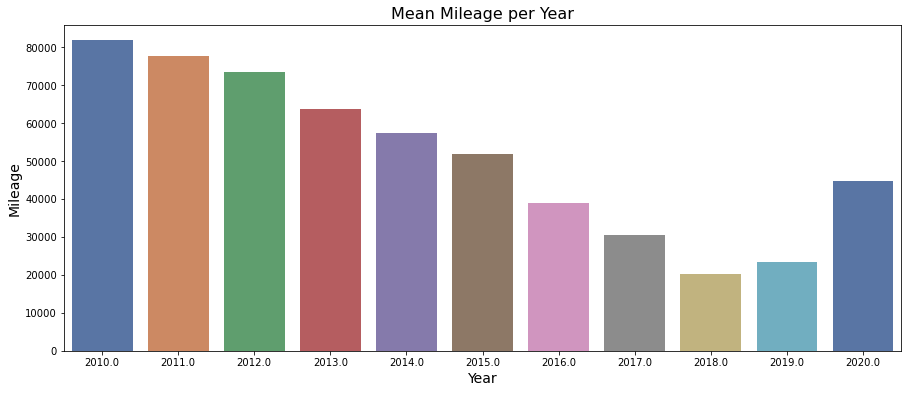

In [30]:
# Display mileage of vehicles with zero previous owners and registered in the past 10 years.
auto_mile_yr = auto_cp[auto_cp.Past_Owners==0].loc[:,['Mileage', 'Year']]

# Group by the mean mileage per year
mean_mile_yr = auto_mile_yr[auto_mile_yr.Year>=2010].groupby(['Year']).mean().reset_index()

# Plot the mean mileage per year
plt.figure(figsize=(15,6))
sns.barplot(mean_mile_yr.Year, mean_mile_yr.Mileage, palette="deep")
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mileage', fontsize=14)
plt.title('Mean Mileage per Year', fontsize=16);

There seems to be a downward trend indicating that the newer the vehicle, the more likely for it to have done lesser mileage. However, looking at years 2019 and 2020, reverse is the case.
Let us now examine vehicles registered in 2019 and 2020, and compare the make, mileage and the prices, and see if we find something unexpected.

In [31]:
# Display vehicle Make, Year, Mileage and Prices for vehicles registered in 2019 and 2020
auto_cp.loc[auto_cp.Year>=2019, ['Make', 'Mileage', 'Year', 'Prices']].sort_values(by=['Year','Mileage', 'Prices'], \
                                                                                   ascending=False)

,Make,Mileage,Year,Prices
154,Bentley,85490.008825,2020.0,179850.0
4760,Land,85490.008825,2020.0,71855.0
6872,Land,85490.008825,2020.0,59899.0
6828,Land,85490.008825,2020.0,58000.0
1365,Land,85490.008825,2020.0,57995.0
6850,Land,85490.008825,2020.0,51900.0
54,Land,85490.008825,2020.0,49490.0
6927,Land,85490.008825,2020.0,44499.0
4650,Land,85490.008825,2020.0,43490.0
22111,Lexus,85490.008825,2020.0,38750.0


We notice that there are vehicles with very high mileage and yet very high prices. A 2020 Bentley is very unlikely to have done 85000 miles and yet cost £180,000. The same applies to other vehicle Makes with 85,000 miles. This is very likely the result from replacing missing values with the mean. Therefore we will drop all 2019 and 2020 vehicles with mileage above 30,000 miles, to just keep the data more realistic.

In [32]:
# drop all 2019 and 2020 vehicles with mileage above 30,000 miles
auto_cp = auto_cp.drop(auto_cp[(auto_cp.Year >= 2019) & (auto_cp.Mileage > 30000)].index)

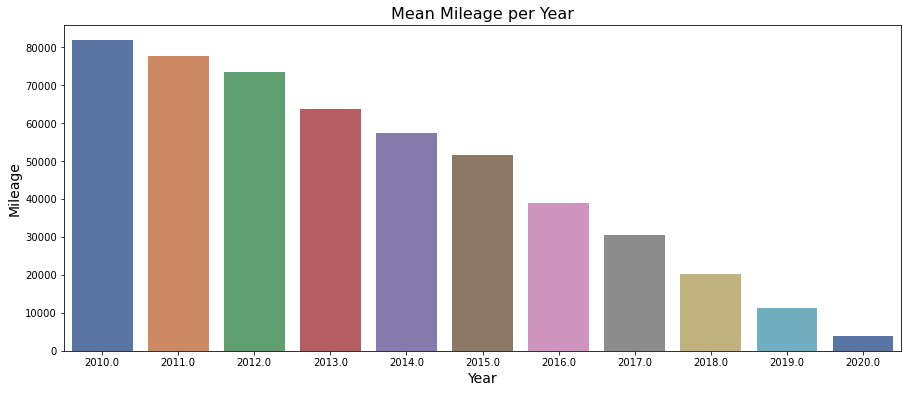

In [33]:
# Display mileage of vehicles with zero previous owners and registered in the past 10 years.
auto_mile_yr = auto_cp[auto_cp.Past_Owners==0].loc[:,['Mileage', 'Year']]

# Group by the mean mileage per year
mean_mile_yr = auto_mile_yr[auto_mile_yr.Year>=2010.0].groupby(['Year']).mean().reset_index()

# Plot the mean mileage per year
plt.figure(figsize=(15,6))
sns.barplot(mean_mile_yr.Year, mean_mile_yr.Mileage, palette="deep")
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mileage', fontsize=14)
plt.title('Mean Mileage per Year', fontsize=16);

The plot shows a more realistic trend of mileage per the age of the car.

In [34]:
# Check descriptive statistics of numerical features
auto_cp.describe()

,Doors,Year,Mileage,Engine_Size,Past_Owners,HorsePower,Prices
count,8944.000000,8944.000000,8944.000000,8944.000000,8944.000000,8944.000000,8944.000000
mean,4.177095,2009.424083,82240.222948,1.746055,2.086315,97.199308,4739.073569
std,1.097560,5.156507,40501.383336,0.557636,1.972509,63.158724,8353.408971
min,0.000000,1962.000000,1000.000000,0.600000,0.000000,10.000000,102.000000
25%,3.000000,2006.000000,55081.000000,1.400000,0.000000,64.000000,1747.250000
50%,5.000000,2010.000000,80000.000000,1.600000,2.000000,95.000000,3146.000000
75%,5.000000,2013.000000,104849.000000,2.000000,4.000000,136.000000,5650.000000
max,9.000000,2020.000000,821870.000000,6.800000,9.000000,604.000000,339950.000000


In [35]:
# Check descriptive statistics of categorical features
auto_cp.describe(include='O')

,Make,Model,Body_Type,Gearbox,Fuel
count,8944,8944,8944,8944,8944
unique,64,962,31,2,3
top,Vauxhall,Corsa,Hatchback,Manual,Petrol
freq,1116,341,5107,7088,5439


The "top" row shows the most popular car make, model, body type, transmission and fuel type of all postings in the dataset.

#### Display the number of Vehicle Makes in the dataset

In [36]:
# Display the counts per vehicle Make
auto_cp.Make.value_counts().sort_index()

Abarth             13
Alfa               63
Audi              504
Austin              2
BMW               739
Bentley             5
Buick               1
Chevrolet          31
Chrysler           17
Citroen           290
DS                  7
Dacia              30
Daewoo              1
Daihatsu           10
Daimler             2
Dodge               2
Ferrari             5
Fiat              301
Ford              918
Honda             242
Hyundai           159
Infiniti            1
Isuzu               5
Jaguar            101
Jeep               22
KIA               135
Land              114
Lexus              52
Lincoln             1
London              2
MAZDA               1
MG                 54
MINI              371
Mazda              88
Mazda2             26
Mazda3             27
Mazda5              9
Mazda6             31
Mercedes            1
Mercedes-Benz     407
Mitsubishi         77
Morris              4
Nissan            248
Perodua             1
Peugeot           437
Porsche   

Notice that we have Mercedes-Benz and Mercedes, and they both refer to the same vehicle Make. We will therefore have to rename this, to have a common name.

The data also shows multiple names for the Mazda product, containing the model identifier. With `value_counts()`, we want to see unique vehicle Makes and not the models. So we will also rename this to have one common name.

In [37]:
# Replace all instances of "Mercedes-Benz" with "Mercedes"
auto_cp.Make = auto_cp.Make.apply(lambda x: x.replace("Mercedes-Benz", "Mercedes"))

# Apply a lambda function to return only the non-numeric characters in the vehicle makes
# converts each vehicle make to upper case
auto_cp.Make = auto_cp.Make.apply(lambda x: ''.join(i for i in x if not i.isdigit()).upper())

auto_cp.Make.value_counts().sort_index()

ABARTH           13
ALFA             63
AUDI            504
AUSTIN            2
BENTLEY           5
BMW             739
BUICK             1
CHEVROLET        31
CHRYSLER         17
CITROEN         290
DACIA            30
DAEWOO            1
DAIHATSU         10
DAIMLER           2
DODGE             2
DS                7
FERRARI           5
FIAT            301
FORD            918
HONDA           242
HYUNDAI         159
INFINITI          1
ISUZU             5
JAGUAR          101
JEEP             22
KIA             135
LAND            114
LEXUS            52
LINCOLN           1
LONDON            2
MAZDA           182
MERCEDES        408
MG               54
MINI            371
MITSUBISHI       77
MORRIS            4
NISSAN          248
PERODUA           1
PEUGEOT         437
PORSCHE          22
PROTON            3
RENAULT         374
REVA              1
ROLLS-ROYCE       3
ROVER            27
SAAB             56
SEAT            204
SKODA           123
SMART            29
SSANGYONG         5


## 3.2 - Exploration of the Features

#### Visualize Target Variable  (Price)

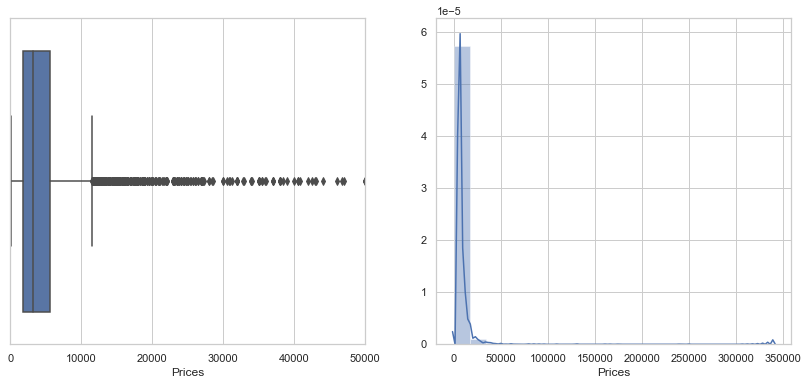

In [38]:
# Set the aesthetic style of the seaborn plots
sns.set(style ="whitegrid")

# Set the plot size
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
plt.xlim(0,50000)
sns.boxplot(auto_cp.Prices)

plt.subplot(1,2,2)
sns.distplot(auto_cp.Prices, bins=20)
plt.show()

The price variable indicates the presence of potential outliers. Let's calculate the skewness of the price variable.
- If skewness = 0: dataset is normally distributed. 
- If skewness > 0 : more weight in the left tail of the distribution. 
- if skewness < 0 : more weight in the right tail of the distribution

In [39]:
auto_cp.Prices.skew()

18.64811611154022

Well, the data confirms the price variable is more weighted in the left tail of the distribution, i.e. right-skewed.
#### Identify outliers using Interquartile Range (IQR) rule
The interquartile range (IQR) is the difference between the first quartile (25%) and third quartile (75%). The range gives us a measurement of how spread out the entirety of our data set is. The interquartile range, which tells us how far apart the first and third quartile are, indicates how spread out the middle 50% of our set of data is. IQR is advantageous over other measurements for spread of datasets like range, in that it is not sensitive to outliers. It informs us whether we have a mild or strong outlier.

In [40]:
# Check descriptive statistics of Price variable
price_st = auto_cp.Prices.describe()
print(price_st)

count      8944.000000
mean       4739.073569
std        8353.408971
min         102.000000
25%        1747.250000
50%        3146.000000
75%        5650.000000
max      339950.000000
Name: Prices, dtype: float64


In [41]:
# Compute the Interquartile Range
IQR = price_st['75%'] - price_st['25%']

# Compute the upper and lower bounds
outlier_upper_bound = price_st['75%'] + 1.5 * IQR
outlier_lower_bound = price_st['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspicious outliers are {} and {}, respectively.'\
      .format(outlier_upper_bound, outlier_lower_bound))

The upper and lower bounds for suspicious outliers are 11504.125 and -4106.875, respectively.


In [42]:
# Checking outliers with prices below the outlier_lower_bound
auto_cp[auto_cp.Prices < outlier_lower_bound]

,Make,Model,Doors,Year,Body_Type,Mileage,Engine_Size,Gearbox,Fuel,Past_Owners,HorsePower,Prices


This is clearly unrealistic, no vehicle will be sold for £0 or for a negative value.

In [43]:
# Checking outliers with prices above the outlier_upper_bound
# Group by vehicle make and registration year, and sort by year
auto_cp[auto_cp.Prices > outlier_upper_bound].groupby(['Make','Year']).size().reset_index().sort_values('Year', ascending=True)

,Make,Year,0
112,RENAULT,1986.0,1
20,CHEVROLET,1986.0,1
27,FORD,1992.0,1
95,NISSAN,1996.0,1
128,TOYOTA,1997.0,1
103,PORSCHE,2001.0,1
104,PORSCHE,2002.0,1
105,PORSCHE,2003.0,1
91,MITSUBISHI,2005.0,1
8,BENTLEY,2006.0,1


We could be suspicious that the following vehicles would cost more than £11504.125

- Renault (1986)
- Chevrolet (1986)
- Ford    (1992)
- Nissan  (1996)
- Toyota  (1997)

But a little search on Autotrader shows indeed a few of the rare models go for such high values. So we would not consider these as outliers, and therefore will retain the data.

In [44]:
# Convert registration year to integer values 
auto_cp['Year'] = auto_cp['Year'].astype('int')

## 3.3 - How correlated are the features to the target

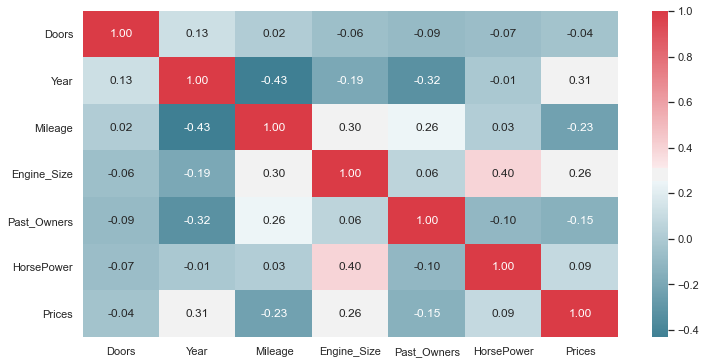

In [45]:
# Set the plot size
plt.figure(figsize = (12, 6))

# Display a heatmap of the dataset
sns.heatmap(auto.corr(), annot=True, fmt=".2f", cmap=sns.diverging_palette(220, 10, as_cmap=True))

The more red the box is, the more positively correlated the feature is to car price. Also, the darker the blue, the more negative the correlation. 
We see that vehicle registration year, mileage done, engine and past owners are more correlated to vehicle price than other numerical features. Let us further explore each feature.

## 3.4 - Define functions to visually compare features with target variable

In [46]:
def compare_feature_price(df, col, rotation='rotation' , title='title', xlabel='xlabel', ylabel='ylabel', fontsize=16):
    """
       Function to plot both numeric and categorical features in the dataset  
       
       args:
           df: dataframe of the dataset sorted by Prices in ascending order
           col: the column to compare with prices
           rotation: angle of rotation for the x-axis ticks
           title: title for the plot
           xlabel: label for the x axis
           ylabel: label for the y axis
           fontsize: size of x-axis, y-axis and title font
    """
    # state the plot size 
    plt.figure(figsize = (15, 6))
       
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        mean = df.groupby(col)['Prices'].mean()
        mean.plot()
        
    else:
        #if column is not numeric then plot the following:
        sns.boxplot(x = col, y = 'Prices', data=df)
        
    #set the labels on the axis    
    plt.xticks(rotation = rotation)
    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.show()

In [47]:
def barplot(index, values, text_tick = True):
    """
        Function to create a bar plot to visualise frequency 
        reports for each features
        
        args:
            index: index of each column 
            values: values of each column 
            text_tick: boolean to decide whether or not to display 
                       text value of each bar       
    """
    
    # Plot the number of posts per hour
    sns.set(style="darkgrid")
    fig = plt.figure(figsize=(15,6))
    ax = sns.barplot(x=index, y=values, palette='deep')
    
    # Set the exact number of posts per hour on each bar
    for p in ax.patches:
        height = p.get_height()
        if text_tick:
            ax.annotate('{}'.format(math.ceil(height)), (p.get_x()+.25, height),
                        xytext = (0, 5), rotation=70, fontsize=12,
                       textcoords="offset points")
        else:
            ax.annotate('{}'.format(math.ceil(height)), (p.get_x()+.25, height),
                        xytext = (0, 5), rotation=70, fontsize=0,
                       textcoords="offset points")

In [48]:
def plot(index, values, rotation=90, ylim=800, title='title', xlabel='xlabel', ylabel='ylabel', fontsize=16, text_tick = True):
    """
        Function to customize the frequency bar plot of each feature
        
        args:
            index: index of each column 
            values: values of each column
            rotation: angle of rotation for the x-axis ticks
            ylim: desired y axis height
            title: title for the plot
            xlabel: label for the x axis
            ylabel: label for the y axis
            fontsize: size of x-axis, y-axis and title font
    """
    barplot(index, values, text_tick)
    plt.ylim(top=ylim)
    plt.xticks(rotation=rotation)
    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.show()

## 3.5 - Compare Make and Prices

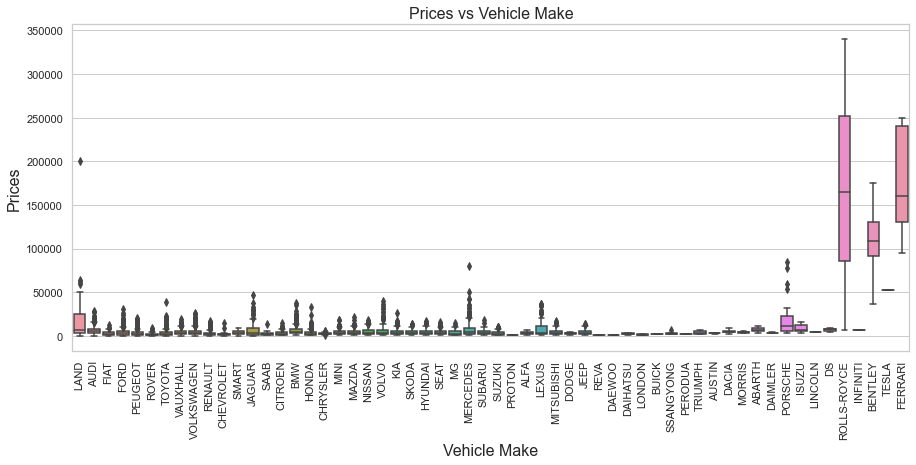

In [49]:
# Boxplot of vehicle make and prices
compare_feature_price(auto_cp.sort_values('Prices',ascending = True), 'Make', 90, \
                      'Prices vs Vehicle Make', 'Vehicle Make', 'Prices')

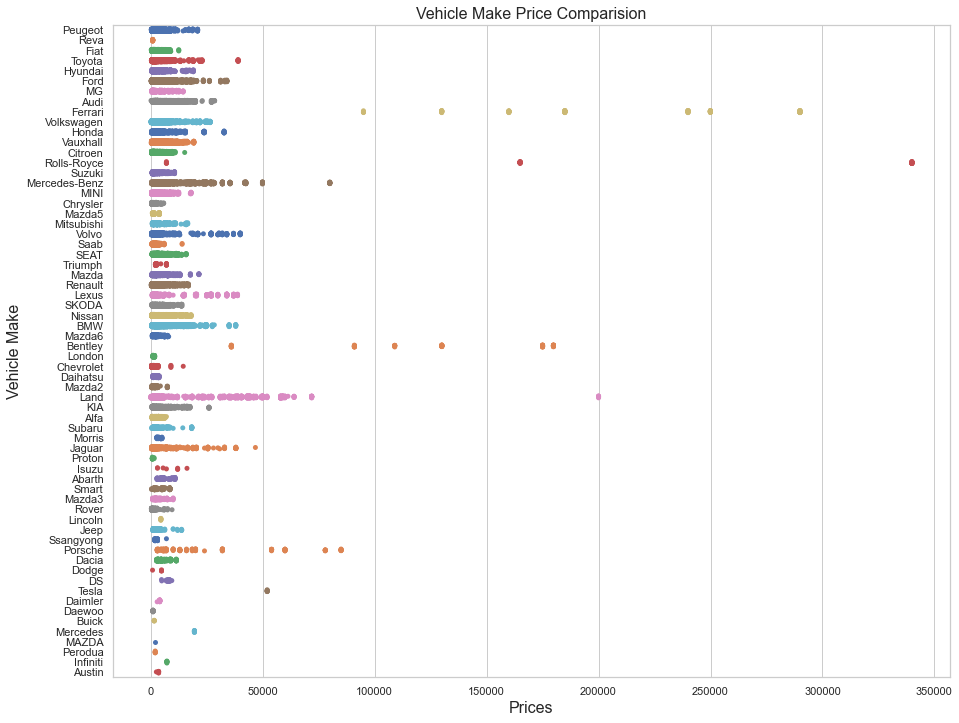

In [50]:
# Set the plot size
plt.subplots(figsize=(15, 12))

# Visualize a stripplot of car Make vs Prices
sns.stripplot(data = auto, x='Prices', y='Make', jitter=.1, palette='deep')
plt.ylabel('Vehicle Make', fontsize=16)
plt.xlabel('Prices', fontsize=16)
plt.title('Vehicle Make Price Comparision', fontsize=16)
plt.show()

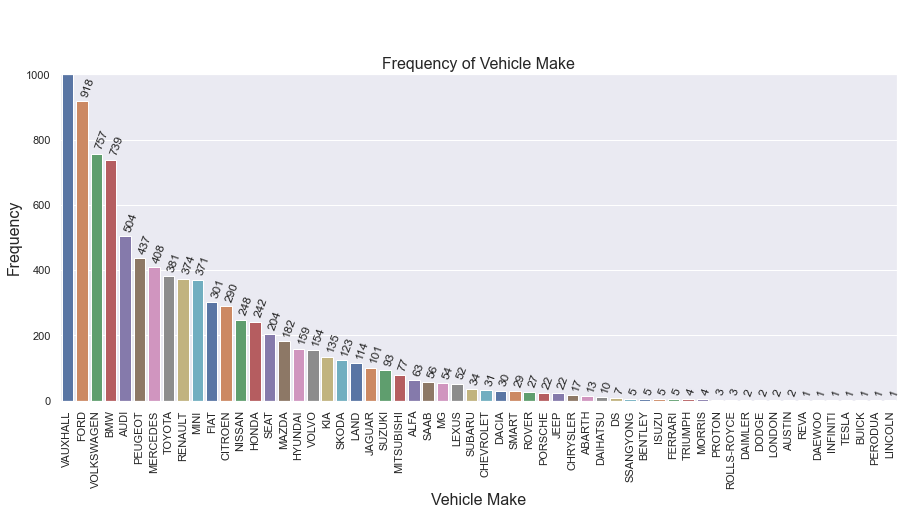

In [51]:
# Frequency count of vehicle make
x = auto_cp.Make.value_counts().index
y = auto_cp.Make.value_counts().values
plot(x, y, 90, 1000, 'Frequency of Vehicle Make', 'Vehicle Make', 'Frequency', 16)

The data sort of correlates with the average passenger vehicles seen on British motorways daily. It only makes sense that sellers will tend to sell more of what's in demand as shown to the left of the plot above. Also it is very clear that luxury brands are generally more expensive than regular vehicles.

As seen from the descriptive statistics summary above, Vauxhall is the most popular product in AutoTrader according to the data.

## 3.6 - Compare Doors and Prices

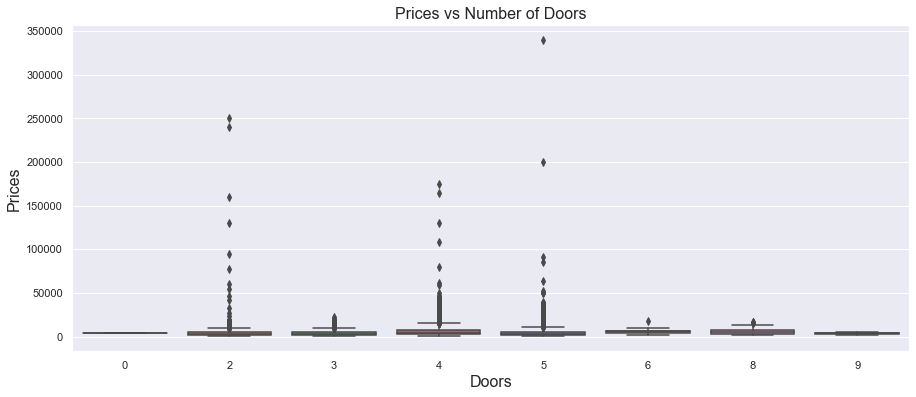

In [52]:
# Convert all entries to integer
auto_cp['Doors'] = auto_cp['Doors'].astype('int')

# Boxplot of number of doors and prices
compare_feature_price(auto_cp.sort_values('Prices',ascending = True), 'Doors', 0 , \
                      'Prices vs Number of Doors', 'Doors', 'Prices')

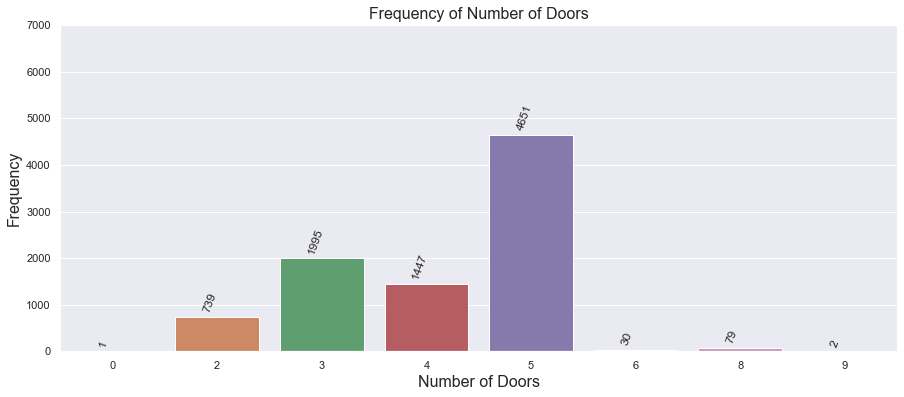

In [53]:
# Frequency count of number of doors
x = auto_cp.Doors.value_counts().index
y = auto_cp.Doors.value_counts().values
plot(x, y, 0, 7000, 'Frequency of Number of Doors', 'Number of Doors', 'Frequency', 16)

Vehicles with 2, 4 or 5 doors seem to be more expensive than other variants, however, there seem to be more demand for 5 door vehicles.

## 3.7 - Compare Year and Prices

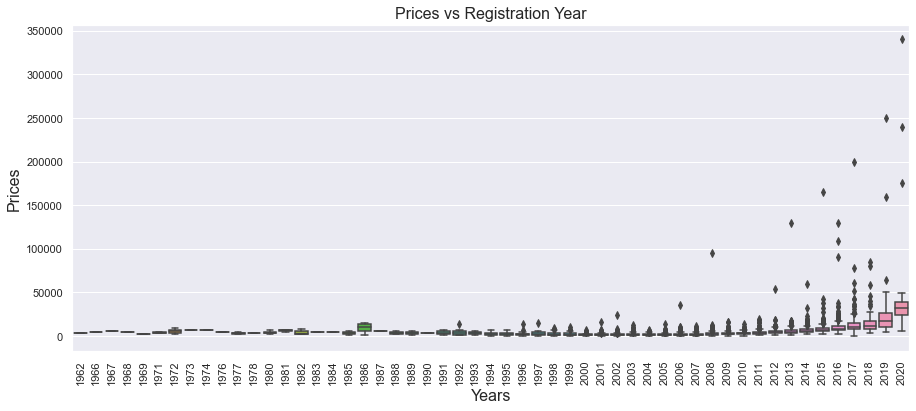

In [54]:
# Boxplot of vehicle registration year and prices
compare_feature_price(auto_cp.sort_values('Prices',ascending = True), 'Year', 90 , \
                      'Prices vs Registration Year', 'Years', 'Prices')

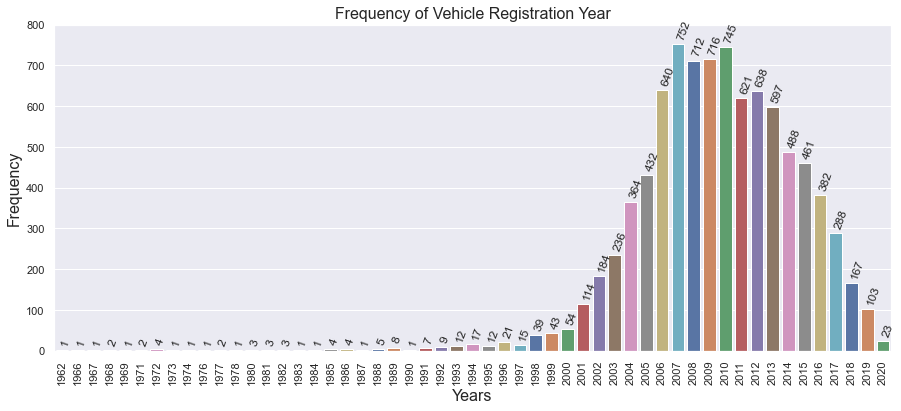

In [55]:
# Frequency count of vehicle registration year
x = auto_cp.Year.value_counts().index
y = auto_cp.Year.value_counts().values
plot(x, y, 90, 800, 'Frequency of Vehicle Registration Year', 'Years', 'Frequency', 16)

The price of the vehicle seem to increase the newer the vehicle is. This trend is generally logical. Most of the vehicles seem to fall between 2001 and 2019.

## 3.8 - Compare Body Type and Price

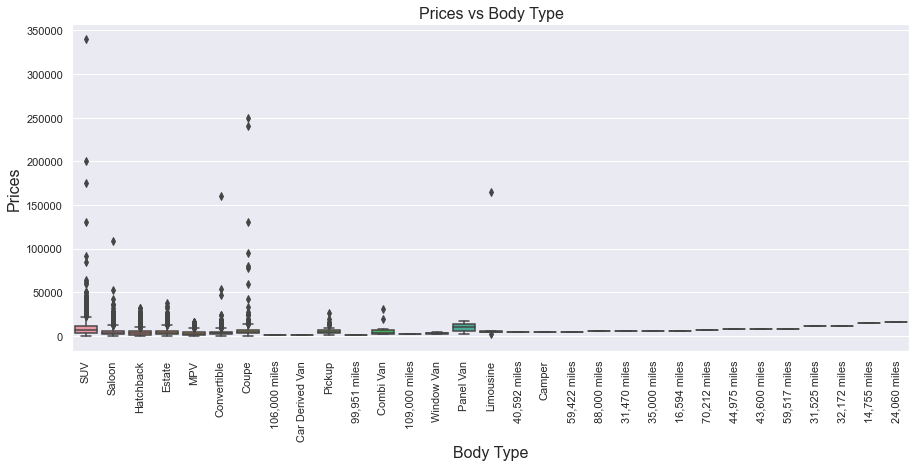

In [56]:
# Boxplot of vehicle body type and prices
compare_feature_price(auto_cp.sort_values('Prices',ascending = True), 'Body_Type', 90, \
                      'Prices vs Body Type', 'Body Type', 'Prices')

This is obviously bad data. Vehicle body type cannot contain miles, so we will delete all rows with miles in the body type.

In [57]:
# Check the length of rows with "miles" included in the Body Type
len(auto_cp[auto_cp.Body_Type.str.contains('miles')])

18

This is a significantly low number, so we willl drop these rows.

In [58]:
# Remove all Body Type values with miles
auto_cp = auto_cp[~auto_cp.Body_Type.str.contains('miles')]

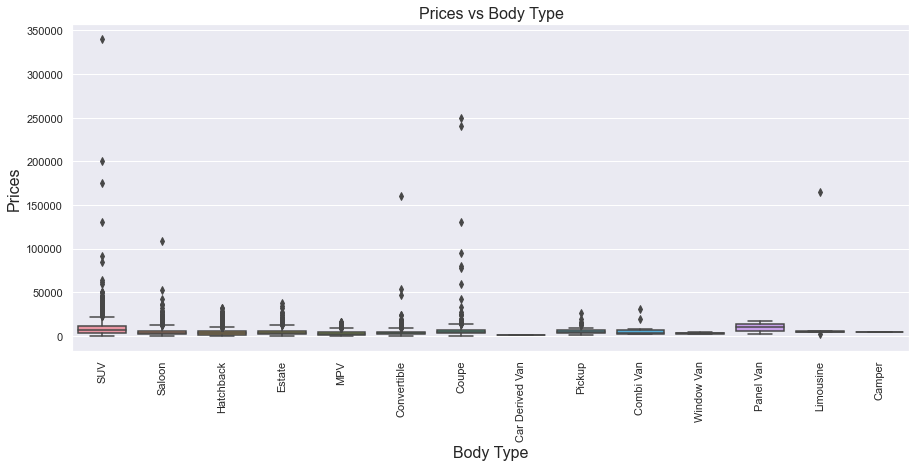

In [59]:
# Visual the body type again 
compare_feature_price(auto_cp.sort_values('Prices',ascending = True), 'Body_Type', 90, \
                      'Prices vs Body Type', 'Body Type', 'Prices')

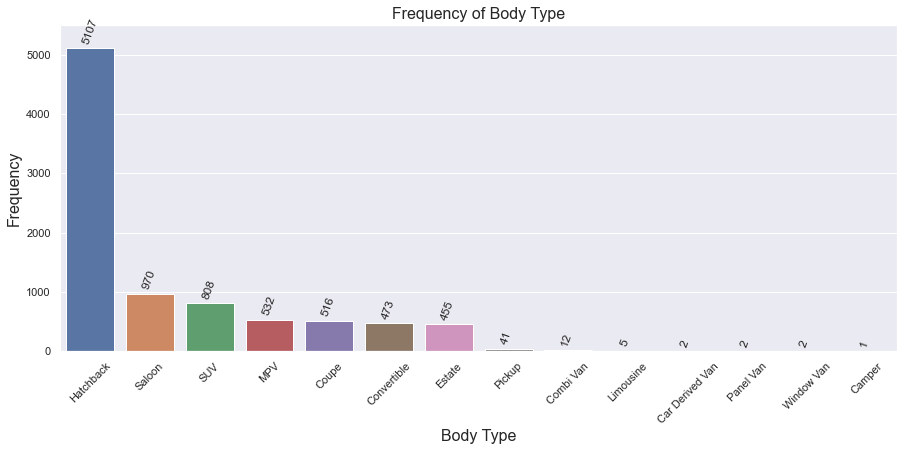

In [60]:
# Frequency count of body type
x = auto_cp.Body_Type.value_counts().index
y = auto_cp.Body_Type.value_counts().values
plot(x, y, 45, 5500, 'Frequency of Body Type', 'Body Type', 'Frequency', 16)

This is quite representative of the vehicles on British road - there seem to be more hatchback cars in the UK. Also as seen from the descriptive statistics summary above, Hatchback type cars are the most popular body type in AutoTrader according to the data.

## 3.9 - Compare Mileage and Prices

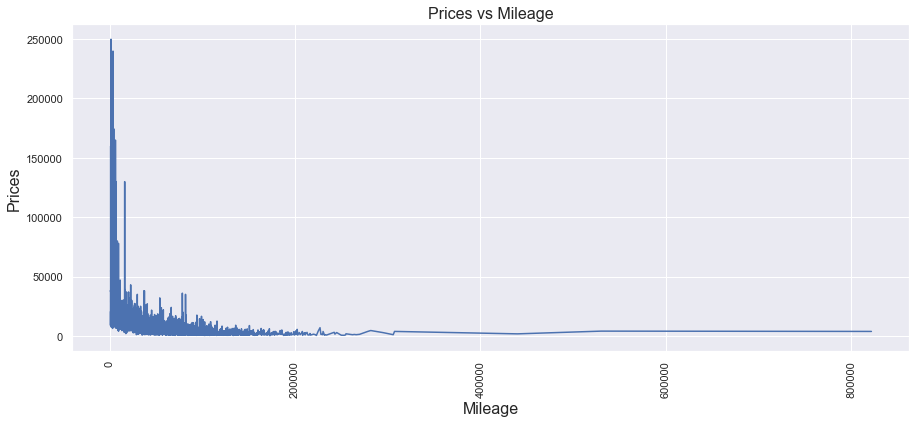

In [61]:
# Boxplot of mileage and prices
compare_feature_price(auto_cp.sort_values('Prices',ascending = True), 'Mileage', 90, 'Prices vs Mileage', 'Mileage', 'Prices')

Quite expected. As the number of mileage completed increases, so does the value of the vehicle reduce. This is because high mileage comes with probability of wear annd tear, and high chances of breakdown than on cars with much lower miles.

## 3.10 - Compare Engine Size with Prices

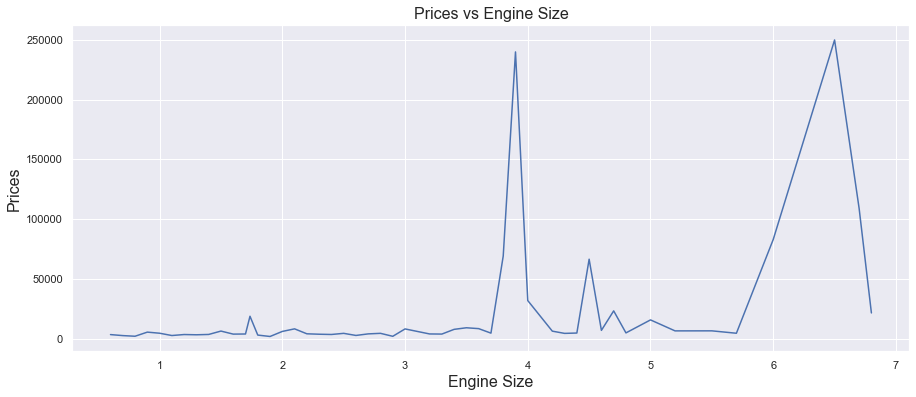

In [62]:
# Boxplot of engine size and prices
compare_feature_price(auto_cp.sort_values('Prices',ascending = True), 'Engine_Size', 0, \
                      'Prices vs Engine Size', 'Engine Size', 'Prices')

Cars with bigger engine sizes tend to cost more than the smaller engine variants.

## 3.11 - Compare Gearbox with Prices

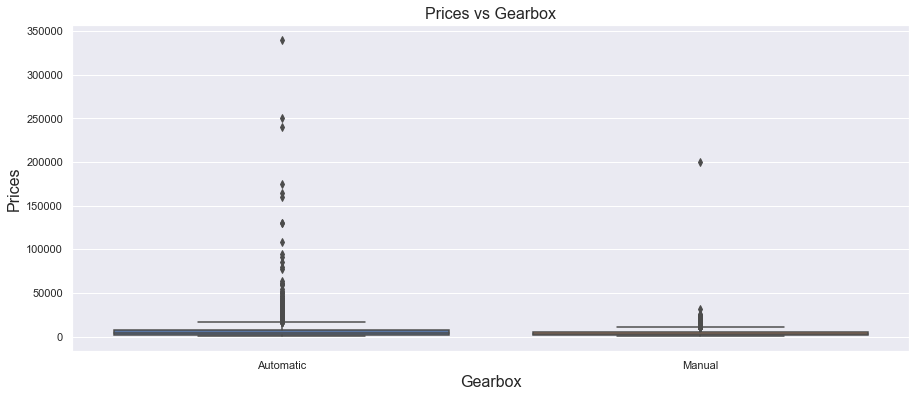

In [63]:
# Boxplot of gearbox and prices
compare_feature_price(auto_cp.sort_values('Prices',ascending = True), 'Gearbox', 0, 'Prices vs Gearbox', 'Gearbox', 'Prices')

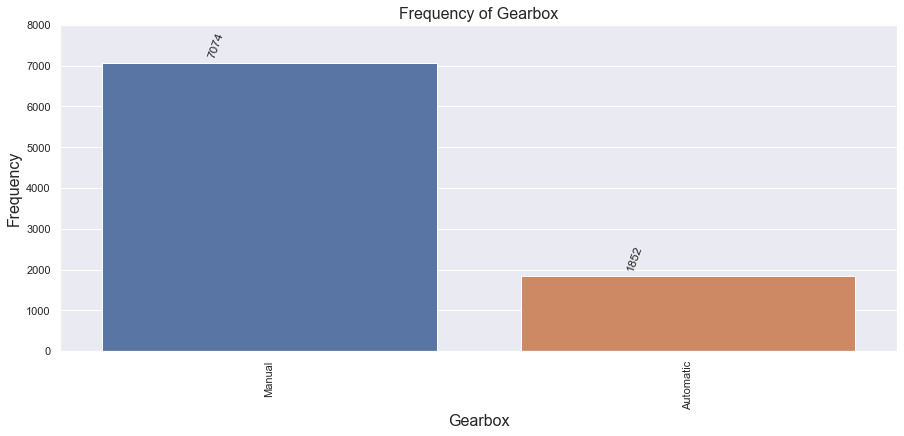

In [64]:
# Frequency count of gearbox
x = auto_cp.Gearbox.value_counts().index
y = auto_cp.Gearbox.value_counts().values
plot(x, y, 90, 8000, 'Frequency of Gearbox', 'Gearbox', 'Frequency', 16)

The data shows that cars with automatic transmissions tend to be more expensive than their manual variants. Also as seen from the descriptive statistics summary above, cars with manual gearbox are the most popular cars in AutoTrader according to the data.

## 3.12 - Compare Fuel type with Prices

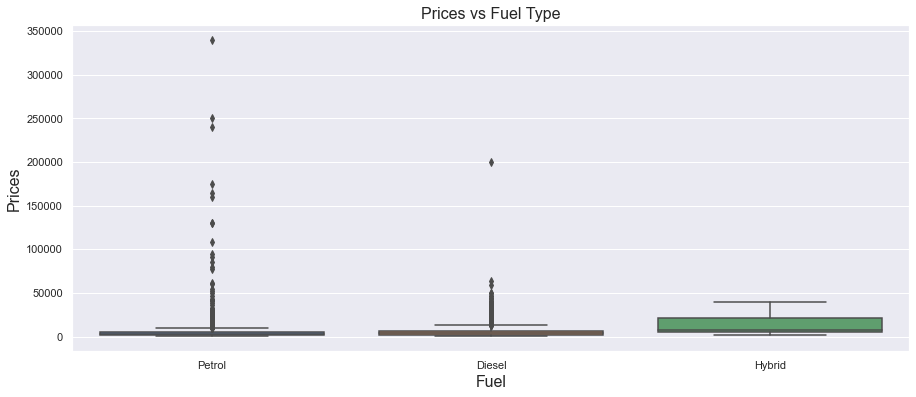

In [65]:
# Boxplot of fuel type and prices
compare_feature_price(auto_cp.sort_values('Prices',ascending = True), 'Fuel', 0, 'Prices vs Fuel Type', 'Fuel', 'Prices')

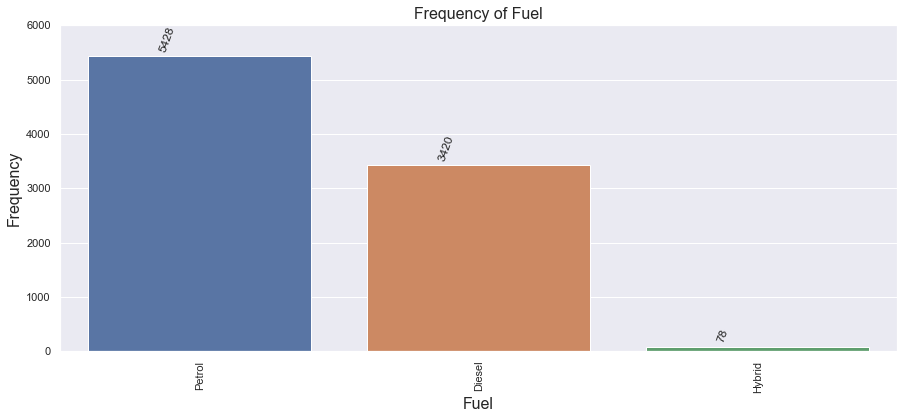

In [66]:
# Frequency count of fuel type
x = auto_cp.Fuel.value_counts().index
y = auto_cp.Fuel.value_counts().values
plot(x, y, 90, 6000, 'Frequency of Fuel', 'Fuel', 'Frequency', 16)

Diesel cars are generally known to be more expensive than petrol cars for multiple reasons but because they are more fuel efficient, they sort of make up for the high purchase cost, meaning running cost of cheaper in the long run.

However, our data shows multiple data points with higher prices for petrol vehicles. Let's explore these and see what Make of cars these are. We will be looking at cars from £100k and above.

In [67]:
# Display cars from £100,000 and above
auto_cp[auto_cp.Prices >= 100000]

,Make,Model,Doors,Year,Body_Type,Mileage,Engine_Size,Gearbox,Fuel,Past_Owners,HorsePower,Prices
180,BENTLEY,Bentayga First,4,2016,SUV,7058.0,6.000000,Automatic,Petrol,0,59.0000,129990.0
2936,BENTLEY,Mulsanne,4,2016,Saloon,18000.0,6.700000,Automatic,Petrol,1,52.0000,108950.0
128,BENTLEY,BENTAYGA V8,4,2020,SUV,3000.0,4.000000,Automatic,Petrol,0,54.0000,174990.0
76,FERRARI,Portofino 3.8T,2,2019,Convertible,1188.0,3.800000,Automatic,Petrol,0,59.0000,159950.0
11,FERRARI,812 SUPERFAST,2,2019,Coupe,1535.0,6.500000,Automatic,Petrol,0,79.0000,249950.0
206,FERRARI,F8 TRIBUTO,2,2020,Coupe,3700.0,3.900000,Automatic,Petrol,0,71.0000,239950.0
15931,FERRARI,458,2,2013,Coupe,16300.0,4.500000,Automatic,Petrol,5,562.0000,129950.0
13232,LAND,Rover Range,5,2017,SUV,31000.0,2.000000,Manual,Diesel,1,15.0000,199999.0
37,ROLLS-ROYCE,Cullinan 5dr,5,2020,SUV,4500.0,1.736581,Automatic,Petrol,0,96.3883,339950.0
24,ROLLS-ROYCE,Phantom 4dr,4,2015,Limousine,6324.0,1.736581,Automatic,Petrol,0,96.3883,164950.0


These are top luxury brands, with mostly petrol engines. This explains the data points with high prices for petrol cars.

In [68]:
# Group the data by Fuel type and aggregate the mileage data
auto_cp.groupby('Fuel')['Prices'].mean().reset_index(name='Mean_Mileage').sort_values(by='Mean_Mileage', ascending=False)

,Fuel,Mean_Mileage
1,Hybrid,13649.179487
0,Diesel,5405.005556
2,Petrol,4184.597458


The data shows that, on the average, diesel cars are more expensive than the petrol variants, with hybrid cars costing the most.

## 3.13 - Compare Past Owners with Prices

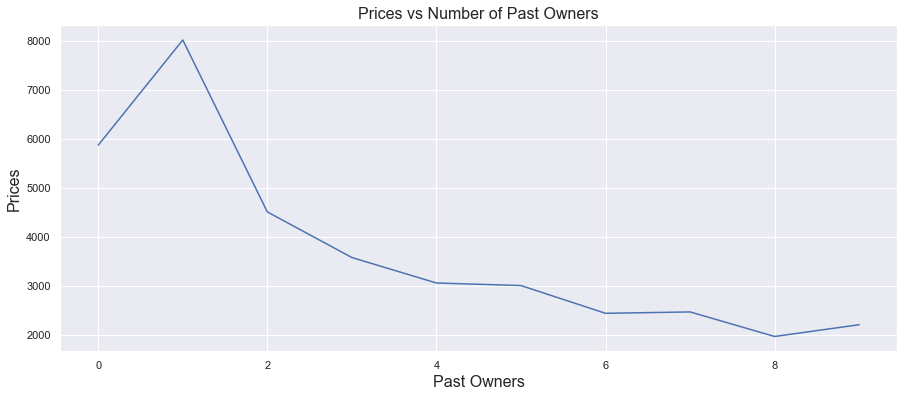

In [69]:
# Boxplot of past owners and prices
compare_feature_price(auto_cp.sort_values('Prices',ascending = True), 'Past_Owners', 0, \
                      'Prices vs Number of Past Owners', 'Past Owners', 'Prices')

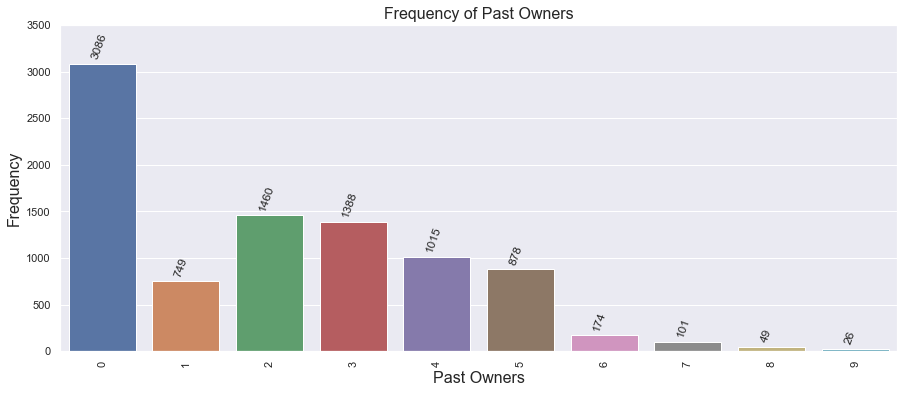

In [70]:
# Frequency count of past owners
x = auto_cp.Past_Owners.value_counts().index
y = auto_cp.Past_Owners.value_counts().values
plot(x, y, 90, 3500, 'Frequency of Past Owners', 'Past Owners', 'Frequency', 16)

The car price is very likely to drop with increasing number of people who have owned the car in the past. The past owners features also shows 3086 cars with no past owners. A typical car posted on AutoTrader would have at least one past owner, or none for a fairly new car. For a brand new car, you would expect about <20 miles on the odometer when delivered to the dealer. This consists of miles at the factory, loading onto a transporter to the destination transportation such as a rail head, loading and unloading there, and onto the dealer's lot from the transporter. 

In [71]:
# Display mileage of vehicles with zero previous owners and registered in the past 5 years.
auto_mile_yr = auto_cp[auto_cp.Past_Owners==0].loc[:,['Mileage', 'Year']]

# Group by Year and mean of Mileage
auto_mile_yr[auto_mile_yr.Year>=2015.0].groupby(['Year']).mean()

,Mileage
Year,
2015,51764.712264
2016,38946.819140
2017,30370.210526
2018,20016.719626
2019,11233.600000
2020,3862.714286


From the analysis above, we have kept all cars registered in 2019 and 2020 with 30,000 miles or less. This gives us an average mileage of 3862 miles for 2020 registered cars, which makes a lot of sense as the coronavirus pandemic would mean less travel for a lot of people.

## 3.14 - Compare HorsePower with Prices

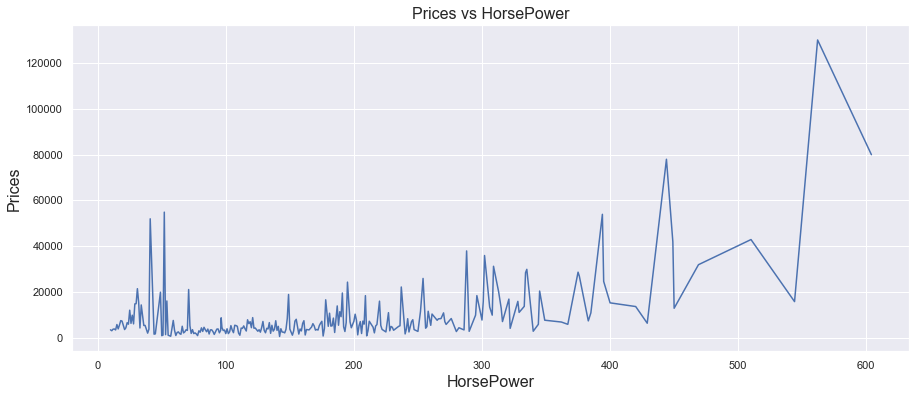

In [72]:
# Boxplot of horsepower and prices
compare_feature_price(auto_cp.sort_values('Prices',ascending = True), 'HorsePower', 0, \
                      'Prices vs HorsePower', 'HorsePower', 'Prices')

Horsepower refers to the power an engine produces. Clearly it influences the price of a car. The higher the horsepower, the more powerful the car, and therefore the more expensive it could be.

## 3.15 - Distribution of Fuel Type Against Registration Year

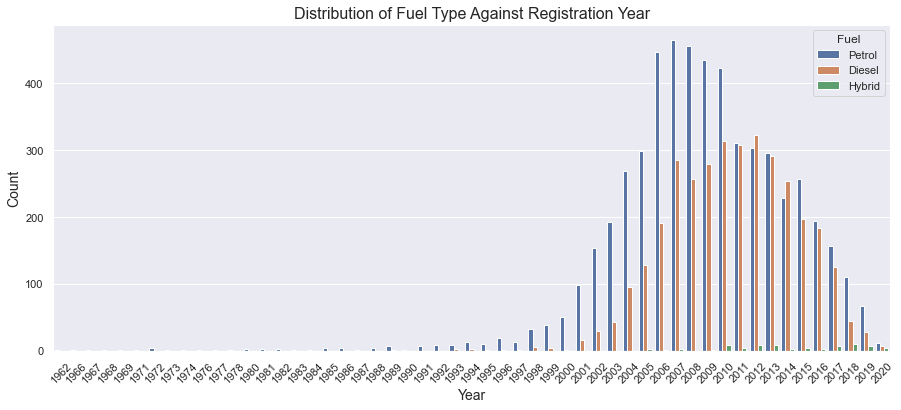

In [73]:
# Set the plot size
plt.figure(figsize=(15,6))

# Display a count/frequency plot
sns.countplot(x='Year', hue='Fuel', data=auto_cp, palette='deep')
plt.xticks(rotation=45)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Fuel Type Against Registration Year', fontsize=16);

The data reveals that petrol vehicles were possibly dorminant up until the start of 21st century, and then diesel engines began flooding the market. It feels like people are more likely to buy petrol powered vehicles than diesel vehicles, as sellers would want to sell more of what buyers are likely to purchase.

## 3.16 - Price Distribution by Gearbox for different fuel types

<Figure size 1440x720 with 0 Axes>

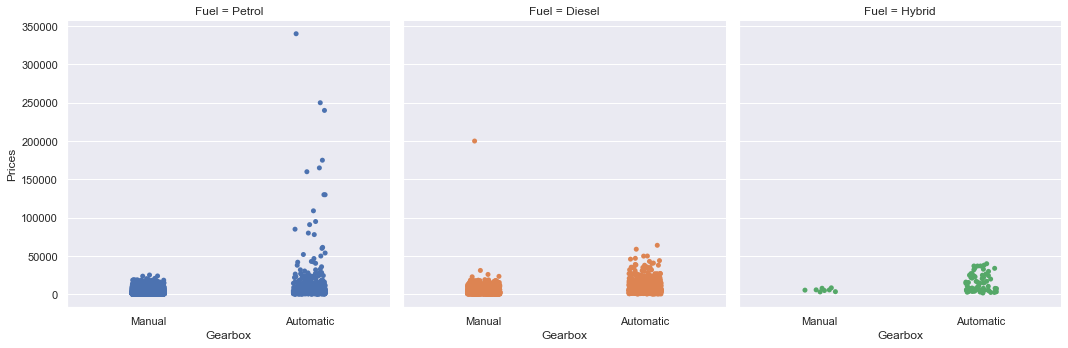

In [74]:
# Set the plot size
plt.figure(figsize=(20,10))

# Visualize a Categorical scatter plot
sns.catplot(x='Gearbox', y='Prices', hue='Fuel', col='Fuel', data=auto_cp, palette='deep');

Most of the vehicles listed in AutoTrader seem to fall within a certain range of prices. The plot suggests that vehicles with automatic transmission generally tend to be more expensive than the manual and hybrid variants, irrespective of the transmission type.

## 3.17 - Compute the Most Expensive Vehicle Makes

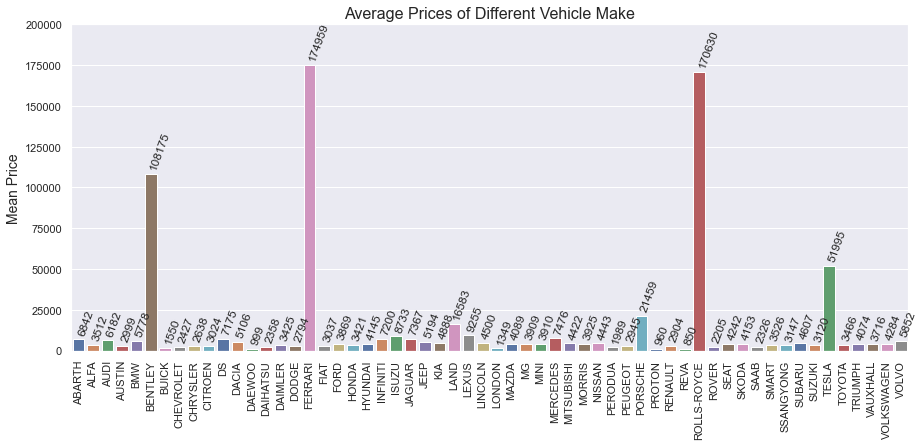

In [75]:
# Dictionary to hold average carprice  for each car Make
avg_car_price = {}

# Loop through the Make column
# take average of car prices for each car Make
for i in auto_cp.Make:
    mean_price = round(np.mean(auto_cp.Prices[auto_cp.Make == i]),2)
    avg_car_price[i] = mean_price
    
# Create the bar plot
x = list(avg_car_price.keys())
y = list(avg_car_price.values())

# call the above bar plot function
barplot(x, y)  
plt.ylim(top=200000)
plt.xticks(rotation=90)
plt.ylabel('Mean Price', fontsize=14)
plt.title('Average Prices of Different Vehicle Make', fontsize=16);

Majority of the vehicles have an average price below £20,000, but this is not conclusive of all vehicles on the website. However this clearly shows a distinction between regular cars and the luxury brands (Ferrari, Bentley, Rolls-Royce, Tesla, Porsche, Land Rover, Mercedes).

## 3.18 - Explore Model and Price Distribution by Vehicle Model

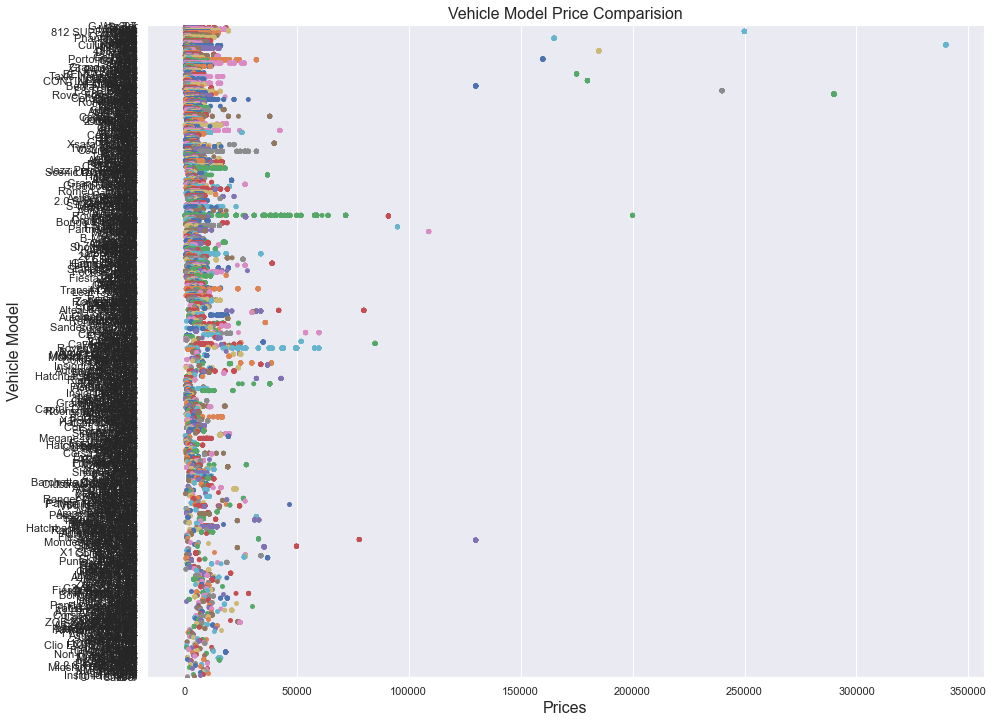

In [76]:
# Set the plot size
plt.subplots(figsize=(15, 12))

# Visualize a stripplot of car Make vs Prices
sns.stripplot(data = auto, x='Prices', y='Model', jitter=.1, palette='deep')
plt.ylabel('Vehicle Model', fontsize=16)
plt.xlabel('Prices', fontsize=16)
plt.title('Vehicle Model Price Comparision', fontsize=16);

Price distribution by vehicle model shows a similar distribution as vehicle make. So to keep the data points simple, we will use only the vehicle make for prediction, and drop the Model column.

In [77]:
# Drop the Model column
auto_cp.drop('Model', axis=1, inplace=True)

# Convert the mileages to integer values
auto_cp['Mileage'] = auto_cp['Mileage'].apply(lambda x: int(x))

# Display first five rows
auto_cp.head()

,Make,Doors,Year,Body_Type,Mileage,Engine_Size,Gearbox,Fuel,Past_Owners,HorsePower,Prices
2777,ABARTH,3,2011,Hatchback,81000,1.400000,Manual,Petrol,3,16.0000,4400.0
3020,ABARTH,3,2011,Hatchback,60000,1.400000,Manual,Petrol,0,135.0000,5695.0
24737,ABARTH,3,2015,Hatchback,17240,1.400000,Manual,Petrol,2,15.0000,10795.0
5457,ABARTH,3,2013,Hatchback,51825,1.736581,Manual,Petrol,0,96.3883,6250.0
2357,ABARTH,3,2015,Hatchback,61000,1.400000,Manual,Petrol,3,160.0000,7995.0


Having performed the above analysis, let us attempt answering the questions posed in the beginning of this notebook.

## Question 1: Do cars with bigger engine sizes accumulate more mileage than cars with smaller engine sizes?

The size of an engine refers to the total volume of air and fuel being pushed through the engine by the cylinders. For example, a 1,000cc engine can displace one litre (1,000 cubic centimetres) of this air-fuel mixture. It would be labelled a 1.0-litre engine. A high displacement engine means more air and fuel mixture, creating more power, which is most suitable for regular motorway commuters. One can hypothesize that people who buy cars with bigger engine size are more likely to be regular motorway commuters than people who drive more around the city, and therefore more likely to have higher mileage readings.

So we will investigate if there is correlation between car engine size and mileage completed.

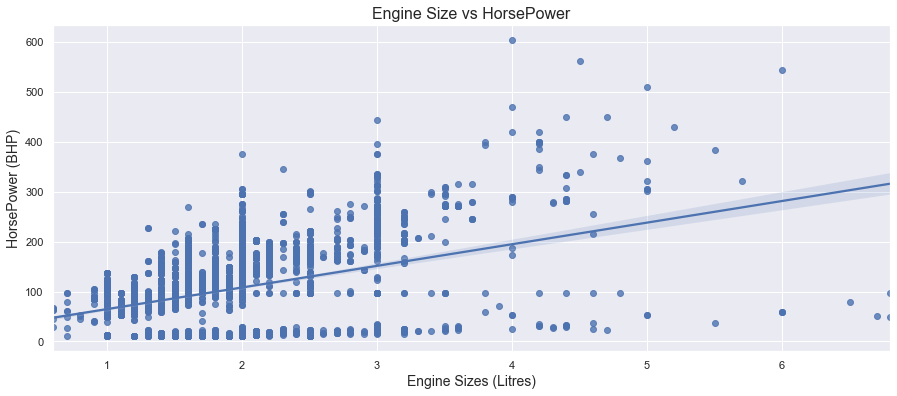

In [78]:
# Convert the engine sizes to a single decimal place
auto_cp.Engine_Size = auto_cp.Engine_Size.apply(lambda x: round(x,1))

# Visualize the relationship between engine size and horsepower
plt.figure(figsize=(15,6))
sns.regplot(data=auto_cp, x="Engine_Size", y="HorsePower")
plt.xlabel('Engine Sizes (Litres)', fontsize=14)
plt.ylabel('HorsePower (BHP)', fontsize=14)
plt.title('Engine Size vs HorsePower', fontsize=16);

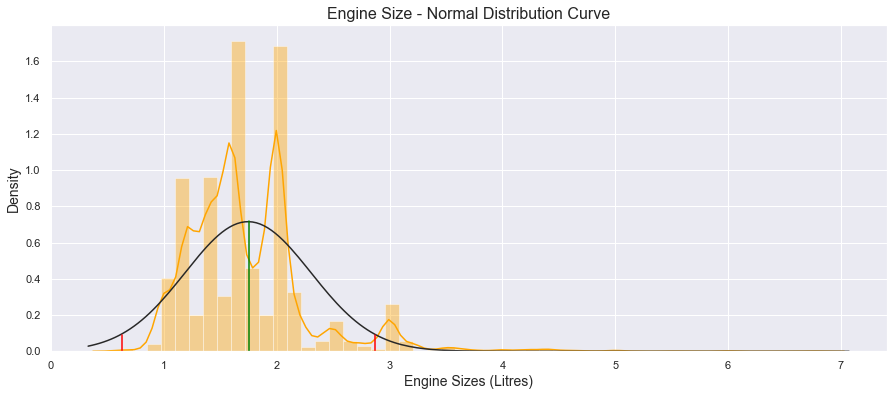

In [81]:
# Compute mean of the Engine size data
mean_es = round(np.mean(auto_cp.Engine_Size),2)

# Compute standard deviation of the Engine size data
std_es = round(np.std(auto_cp.Engine_Size),2)

# Visualize the engine size data
plt.figure(figsize=(15,6))
sns.distplot(auto_cp.Engine_Size , fit=norm, color='orange')
plt.xlabel('Engine Sizes (Litres)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.axvline(mean_es, 0, 0.4, color='green')         # vertical line indicating the mean of the distribution
plt.axvline(mean_es-2*std_es, 0, 0.05, color='red') # vertical line indicating the 2 standard deviation from the mean
plt.axvline(mean_es+2*std_es, 0, 0.05, color='red') # vertical line indicating the 2 standard deviation from the mean
plt.title('Engine Size - Normal Distribution Curve', fontsize=16);

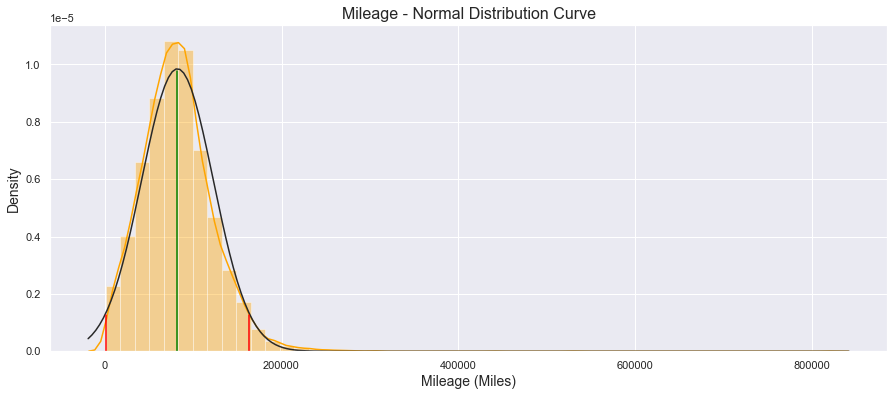

In [82]:
# Compute mean of the mileage data
mean_mile = round(np.mean(auto_cp.Mileage),2)

# Compute standard deviation of the mileage data
std_mile = round(np.std(auto_cp.Mileage),2)

# Visualize the Mileage data
plt.figure(figsize=(15,6))
sns.distplot(auto_cp.Mileage , fit=norm, color='orange')
plt.xlabel('Mileage (Miles)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.axvline(mean_mile, 0, 0.86, color='green')           # vertical line indicating the mean of the distribution
plt.axvline(mean_mile-2*std_mile, 0, 0.11, color='red')  # vertical line indicating the 2 standard deviation from the mean
plt.axvline(mean_mile+2*std_mile, 0, 0.11, color='red')  # vertical line indicating the 2 standard deviation from the mean
plt.title('Mileage - Normal Distribution Curve', fontsize=16);

Most of the engine size and mileage data lie within 2 standard deviations (red vertical lines) from the mean (green vertical line), which is about 95% of the dataset. So let's take the mean as threshold, therfore any engine size bigger than the mean is considered a big engine size, and mileages above the mean mileage are considered high mileage.

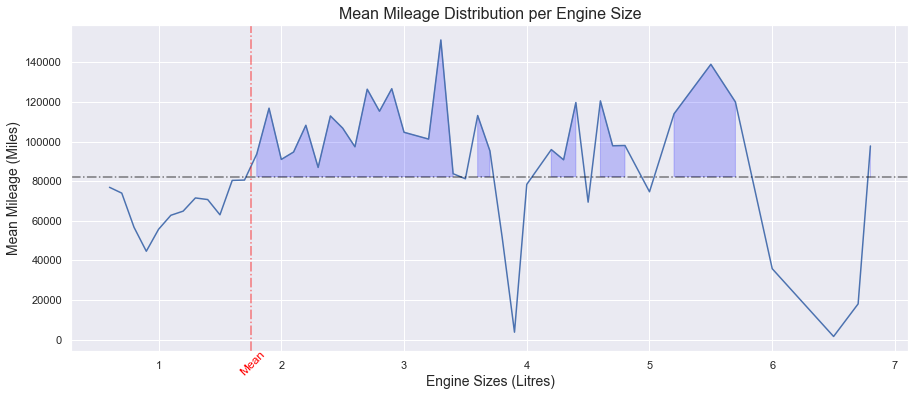

In [83]:
# Visualize the engine size and mileage data
plt.figure(figsize=(15,6))

# Group the dataset by Engine Size and aggregate by Mileage
# Plot the resultant grouped data
engSizeMileage_grp = auto_cp.groupby('Engine_Size')['Mileage'].mean().astype('int')
engSizeMileage_grp.plot()
plt.axvline(mean_es, color='red', linestyle='-.', alpha=0.5)
plt.axhline(mean_mile, color='black', linestyle='-.', alpha=0.5)
plt.text(mean_es-0.1, -18000, 'Mean', color='red', rotation=45)
plt.xlabel('Engine Sizes (Litres)', fontsize=14)
plt.ylabel('Mean Mileage (Miles)', fontsize=14)
plt.title('Mean Mileage Distribution per Engine Size', fontsize=16);

# Fill the region of interest
# Reset the index and rename as Mean_Mileage
engSizeMileage = engSizeMileage_grp.reset_index(name='Mean_Mileage')

# get the engine size values
engine_size = engSizeMileage.Engine_Size.values

# get the mileage values
mileage = engSizeMileage.Mean_Mileage.values

# Fill the region greater than the mean engine size and mean mileage
plt.fill_between(engine_size, mileage, mean_mile, 
                 where=(engine_size >= mean_es) & (mileage >= mean_mile),
                color='blue',
                alpha=0.2);

There is an obvious trend as seen in the graph above. The black dotted horizontal line indicates the mean mileage and the red dotted vertical line indicates the mean engine size. The shaded region shows that most of the vehicles with bigger engine sizes (i.e. above 1.75L) have done above the mean mileage (i.e. 82300 miles). However, there are a few interesting points which do not follow the trend. Let's see what these really are.

In [84]:
# Group the dataset by Make, Year and Engine Size for the point below the mean mileage and greater than the mean engine size
# Display the mean mileage for each row
# Reset the index, and name the new mean mileage column
# Then sort the dataframe by the Engine size
# This is bascially to capture the data points at the bottom right quadrant above
eng_mileage_outlier = auto_cp[((auto_cp.Engine_Size >= 3.5) & (auto_cp.Engine_Size <= 4) | (auto_cp.Engine_Size >= 6)) & \
        (auto_cp.Mileage < mean_mile)].groupby(['Make', 'Year', 'Engine_Size'])['Mileage'].\
                                                        mean().reset_index(name='Mean_Mileage').\
                                                        sort_values(by='Mean_Mileage',ascending=True)

# Display the first five rows
eng_mileage_outlier.head(10)

,Make,Year,Engine_Size,Mean_Mileage
9,FERRARI,2019,3.8,1188
10,FERRARI,2019,6.5,1535
4,BENTLEY,2020,4.0,3000
11,FERRARI,2020,3.9,3700
22,MERCEDES,2018,4.0,8400
3,BENTLEY,2016,6.7,18000
15,LEXUS,2018,3.5,18224
2,BENTLEY,2016,6.0,18529
14,LEXUS,2017,3.5,20500
32,PORSCHE,2018,4.0,21000


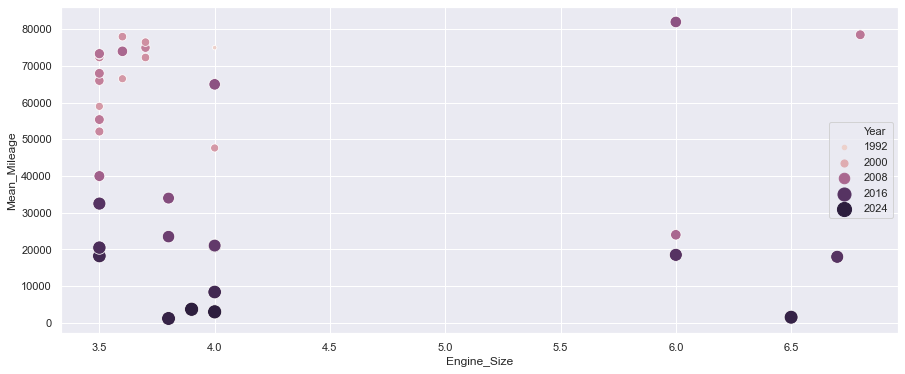

In [85]:
# Set the plot size
plt.figure(figsize=(15,6))

# Display a scather plot of the grouped data
sns.scatterplot(data=eng_mileage_outlier, x="Engine_Size", y="Mean_Mileage", \
                hue='Year', size='Year', sizes=(20,200));

The plot correlates with analysis from earlier in this project. We notice that the older the car, irrespective of engine size, the more mileage the car is expected to have done. There are two points with very big engine sizes and high mileages (top right corner). These points are relatively older cars (Bentley - 2006 & BMW - 2011). The other four points (bottom right corner) with big engine sizes and lower mileages (Bentley - 2016 & Ferrari - 2008, 2019) are both luxury and relatively newer cars, with the expection of the 2008 Ferrari (24k miles).

Therefore with the exception of the above data points, we can conclude with this analysis **`that vehicles with bigger engine sizes are more likely to accumulate higher mileage than the smaller engine variants`**.

## Question 2 - do petrol cars accumulate more miles than diesel cars over their lifetime?
#### Comparison of Fuel Type and Vehicle Mileage

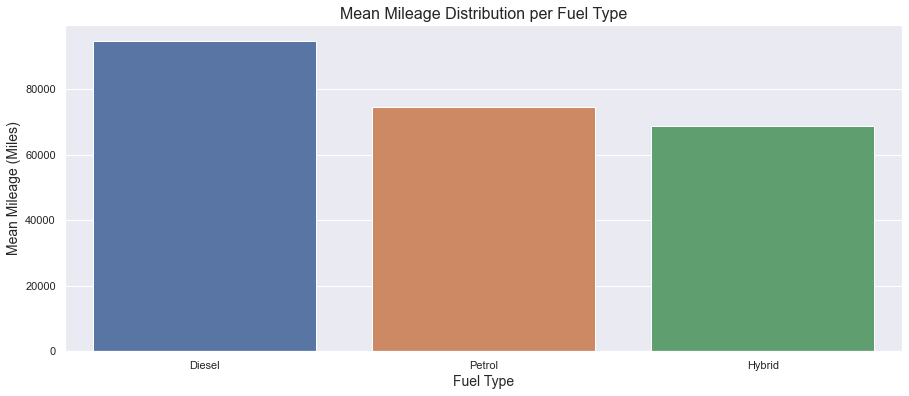

In [86]:
# Set the plot size
plt.figure(figsize=(15,6))

# Group the data by Fuel and aggregate by Mileage
# Display the mean mileage for each row
# Reset the index, and name the new mean mileage column
# Then sort the dataframe by the mean mileage
fuel_mileage = auto_cp.groupby('Fuel')['Mileage'].mean().reset_index(name='Mean_Mileage').sort_values(by='Mean_Mileage', ascending=False)

# Visualize the data
sns.barplot(x='Fuel', y='Mean_Mileage', data=fuel_mileage, palette='deep')
plt.xlabel('Fuel Type', fontsize=14)
plt.ylabel('Mean Mileage (Miles)', fontsize=14)
plt.title('Mean Mileage Distribution per Fuel Type', fontsize=16);

#### Comparison of Fuel Type and Vehicle Engine Size

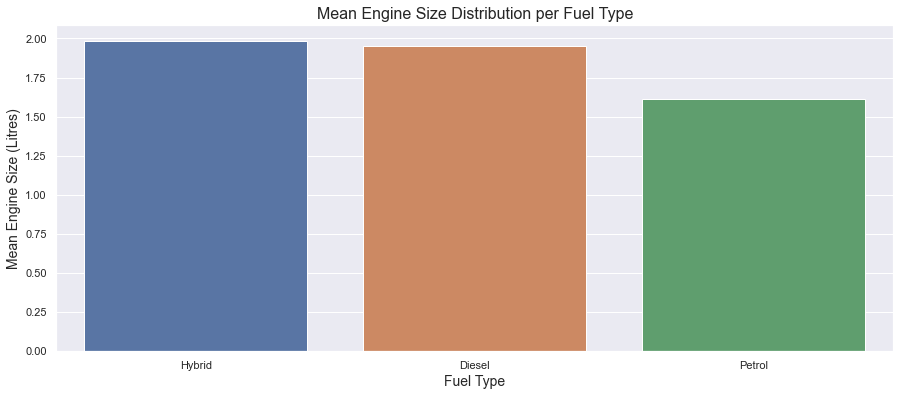

In [87]:
# Set the plot size
plt.figure(figsize=(15,6))

# Group the data by Fuel and aggregate by engine size
# Display the mean engine size for each row
# Reset the index, and name the new mean engine size column
# Then sort the dataframe by the mean engine size
engine_mileage = auto_cp.groupby('Fuel')['Engine_Size'].mean().reset_index(name='Engine_Size').sort_values(by='Engine_Size', ascending=False)

# Visualize the data
sns.barplot(x='Fuel', y='Engine_Size', data=engine_mileage, palette='deep')
plt.xlabel('Fuel Type', fontsize=14)
plt.ylabel('Mean Engine Size (Litres)', fontsize=14)
plt.title('Mean Engine Size Distribution per Fuel Type', fontsize=16);

#### Comparison of Fuel Type and Vehicle Mileage per Registration Year

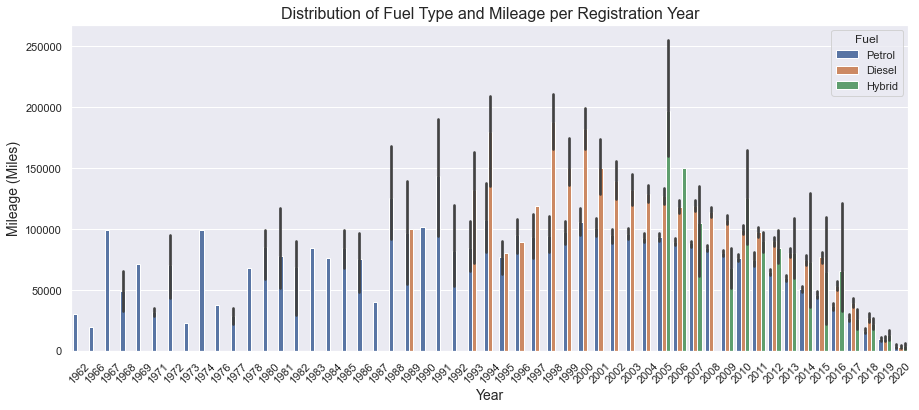

In [88]:
# Set the plot size
plt.figure(figsize=(15,6))

# Visualize the data
sns.barplot(x='Year',y='Mileage', hue='Fuel', data=auto_cp, palette='deep')
plt.xticks(rotation=45)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mileage (Miles)', fontsize=14)
plt.title('Distribution of Fuel Type and Mileage per Registration Year', fontsize=16);

The data shows that, on average, the diesel cars posted on the site have completed more miles than the petrol powered cars. There also seem to be a trend in the past 20 years, that the newer the car, the lesser the mileage the car is likely to have done. We have already established this trend above. Hybrid vehicles in the past 10years+ are gradually becoming the more preferred option, a trend which will continue into the future as Government regulations change, and zero-emission cities are developed.

However, looking at the mileages completed for each variant of car by the fuel type and registered year, the data shows that the most of the diesel cars have completed more mileages than their petrol engine variant. Although there could be exceptions, depending on the user and for what purposes the cars are used, we could conclude based on the above analysis **`that diesel powered cars tend to accumulate more mileages than the petrol-powered cars over their litetime`**. This could be because they are more fuel efficient, and ideal for long distance travels, therefore the owners of diesel cars are likely to travel more than their petol counterparts.

## 3.19 - Computing Correlation of the Features

In [89]:
# Compute pairwise correlation of all the columns, excluding NA/null values.
corr_matrix = auto_cp.corr()
corr_matrix['Prices'].sort_values(ascending=False)

Prices         1.000000
Year           0.349616
Engine_Size    0.221588
HorsePower     0.155683
Doors          0.012047
Past_Owners   -0.157012
Mileage       -0.309061
Name: Prices, dtype: float64

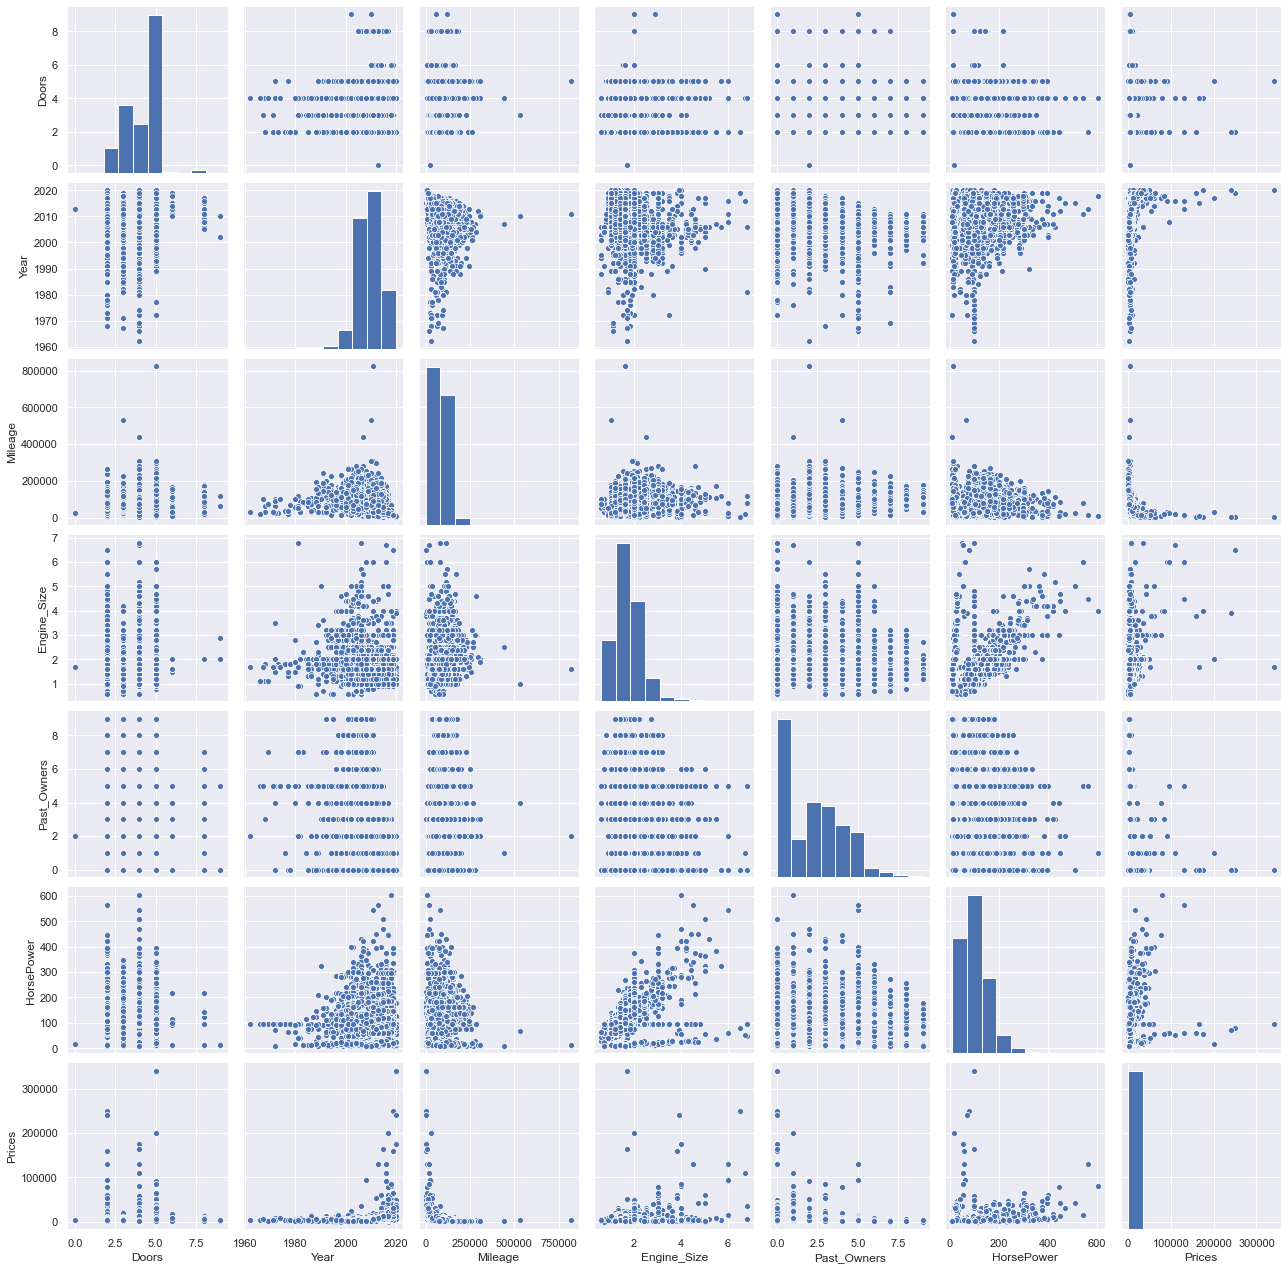

In [90]:
# Plot pairwise relationships in a dataset.
sns.pairplot(auto_cp[corr_matrix.index.tolist()]);

## 3.20 - Summary of Data Exploration
- The registration **year** of the car has a strong positive correlation with the car price. As expected, the newer the car, the more expensive it is expected to be, generally driven by newer technology (safety, comfort, efficiency, etc)
- There is a strong negative correlation between the car **mileage** and the cost of the car. The higher the mileage, the more likely is it prone to wear and tear, and therefore the more likely the price will be lower compared to its newer variants.
- **Engine size** and **horsepower** both have positive correlation with car price. There is an upward trend that shows higher values tend to positively affect the car prices.
- The plot suggests that cars with 2, 4 or 5 **doors** generally are more expensive, but a correlation value of 0.012 does not give any confidence in influencing the price of a car.
- Number of **past owners** have significant influence on the price of the car. The more people who have owned the car in the past, the lower the car price tends to be.
- There seem to be more petrol cars posted on Autotrader than diesel and hybrid cars. However, diesel cars generally seem to be more expensive.
- Cars with manual **Gearbox** seem to dominate the market, with automotive gearbox cars costing more than the manual variant. This could mean that people tend to buy manual cars because they are less expensive, particularly for first time car owners who have just passed  their driving training.
- Hatchback **body type** cars seem to be more popular in the UK, followed by Saloons and SUVs. People in the UK seems to hike or go away for the weekend a lot, which means hatchback cars would provide more cargo area to carry stuff, please they also provide better view out of the rearview mirror.

These features will play a significant part in the prediction of the car price. However, the third question will be answered towards the end of this project, after the best model is chosen and feature importance is computed. We will then compare the result with the above summary.

As some of the features are categorical, we will create a function to create **dummy variables** of these features (also known as **one-hot encoding**) before passing the data to the model. This converts categorical variables into dummy/indicator variables. A data frame is returned with all the possible values after splitting every string. If the text value in the original data frame at same index contains the string (Column name/ Split values), then the value at that position is 1 otherwise, 0.

From the data exploration above, we will select the following features for vehicle price prediction.

**Categorical features**
- Car Make 
- Gearbox
- Fuel type
- Body type

**Numerical features**
- Registration year
- Mileage
- Engine size
- Doors
- Past Owners
- Engine horsepower

## 3.21 - Function to Create Dummy Values for the Categorical Features

In [91]:
def create_dummy_df(df, cat_cols, dummy_na):
    """
        Creates a dummy variable for every unique item of each categorical features
        
        args:
            df - pandas dataframe with categorical variables you want to dummy
            cat_cols - list of strings that are associated with names of the categorical columns
            dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
        returns:
            df - a new dataframe that has the following characteristics:
                1. contains all columns that were not specified as categorical
                2. removes all the original columns in cat_cols
                3. dummy columns for each of the categorical columns in cat_cols
                4. if dummy_na is True - it also contains dummy columns for the NaN values
                5. Use a prefix of the column name with an underscore (_) for separating the dummy column name
    """
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue

    return df

In [92]:
# List of categorical columns
cat_cols = ['Make', 'Gearbox', 'Fuel', 'Body_Type']

# Use the function above to create dummy values for the categorical features
# and join with the numerical features
auto_new = create_dummy_df(auto_cp, cat_cols, dummy_na=False)
auto_new.shape

(8926, 80)

In [93]:
# Display the new columns
auto_new.columns

Index(['Doors', 'Year', 'Mileage', 'Engine_Size', 'Past_Owners', 'HorsePower',
       'Prices', 'Make_ALFA', 'Make_AUDI', 'Make_AUSTIN', 'Make_BENTLEY',
       'Make_BMW', 'Make_BUICK', 'Make_CHEVROLET', 'Make_CHRYSLER',
       'Make_CITROEN', 'Make_DACIA', 'Make_DAEWOO', 'Make_DAIHATSU',
       'Make_DAIMLER', 'Make_DODGE', 'Make_DS', 'Make_FERRARI', 'Make_FIAT',
       'Make_FORD', 'Make_HONDA', 'Make_HYUNDAI', 'Make_INFINITI',
       'Make_ISUZU', 'Make_JAGUAR', 'Make_JEEP', 'Make_KIA', 'Make_LAND',
       'Make_LEXUS', 'Make_LINCOLN', 'Make_LONDON', 'Make_MAZDA',
       'Make_MERCEDES', 'Make_MG', 'Make_MINI', 'Make_MITSUBISHI',
       'Make_MORRIS', 'Make_NISSAN', 'Make_PERODUA', 'Make_PEUGEOT',
       'Make_PORSCHE', 'Make_PROTON', 'Make_RENAULT', 'Make_REVA',
       'Make_ROLLS-ROYCE', 'Make_ROVER', 'Make_SAAB', 'Make_SEAT',
       'Make_SKODA', 'Make_SMART', 'Make_SSANGYONG', 'Make_SUBARU',
       'Make_SUZUKI', 'Make_TESLA', 'Make_TOYOTA', 'Make_TRIUMPH',
       'Make_VAUXHALL

In [94]:
# Display the first five rows of the new dataset
auto_new.head()

,Doors,Year,Mileage,Engine_Size,Past_Owners,HorsePower,Prices,Make_ALFA,Make_AUDI,Make_AUSTIN,Make_BENTLEY,Make_BMW,Make_BUICK,Make_CHEVROLET,Make_CHRYSLER,Make_CITROEN,Make_DACIA,Make_DAEWOO,Make_DAIHATSU,Make_DAIMLER,Make_DODGE,Make_DS,Make_FERRARI,Make_FIAT,Make_FORD,Make_HONDA,Make_HYUNDAI,Make_INFINITI,Make_ISUZU,Make_JAGUAR,Make_JEEP,Make_KIA,Make_LAND,Make_LEXUS,Make_LINCOLN,Make_LONDON,Make_MAZDA,Make_MERCEDES,Make_MG,Make_MINI,Make_MITSUBISHI,Make_MORRIS,Make_NISSAN,Make_PERODUA,Make_PEUGEOT,Make_PORSCHE,Make_PROTON,Make_RENAULT,Make_REVA,Make_ROLLS-ROYCE,Make_ROVER,Make_SAAB,Make_SEAT,Make_SKODA,Make_SMART,Make_SSANGYONG,Make_SUBARU,Make_SUZUKI,Make_TESLA,Make_TOYOTA,Make_TRIUMPH,Make_VAUXHALL,Make_VOLKSWAGEN,Make_VOLVO,Gearbox_Manual,Fuel_Hybrid,Fuel_Petrol,Body_Type_Car Derived Van,Body_Type_Combi Van,Body_Type_Convertible,Body_Type_Coupe,Body_Type_Estate,Body_Type_Hatchback,Body_Type_Limousine,Body_Type_MPV,Body_Type_Panel Van,Body_Type_Pickup,Body_Type_SUV,Body_Type_Saloon,Body_Type_Window Van
2777,3,2011,81000,1.4,3,16.0000,4400.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3020,3,2011,60000,1.4,0,135.0000,5695.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
24737,3,2015,17240,1.4,2,15.0000,10795.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
5457,3,2013,51825,1.7,0,96.3883,6250.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2357,3,2015,61000,1.4,3,160.0000,7995.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [95]:
# Split your data into an X matrix and a response vector y
X = auto_new.drop(['Prices'], axis=1)
y = auto_new.Prices

print("Shape of features: {}".format(X.shape))
print("Shape of target: {}".format(y.shape))

Shape of features: (8926, 79)
Shape of target: (8926,)


# PART 4 - Data Modelling

## 4.1 - Splitting the Data into Training and Test Datasets

In [96]:
# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.20, random_state=42)

print("Size of train dataset: {} rows".format(X_train.shape[0]))
print("Size of test dataset: {} rows".format(X_test.shape[0]))

Size of train dataset: 7140 rows
Size of test dataset: 1786 rows


## 4.2 - Scaling the Training and Test Dataset
Standardize features by removing the mean and scaling to unit variance

In [97]:
# Instantiate the Standardize
scaler = StandardScaler()

# scale the training data
# learn the scaling parameters (mean & variance) of that dataset
X_train = scaler.fit_transform(X_train)

# scale the testing data using the parameters from the training dataset
X_test = scaler.transform(X_test)

In [98]:
# Display first two arrays of the scaled training dataset
X_train[:2]

array([[-1.07615466, -0.08113111, -0.0635083 , -0.78701239,  0.46255628,
        -0.10074502, -0.07963978, -0.24134645, -0.01673889, -0.02367569,
        -0.30151134, -0.01183536, -0.05559457, -0.04739124, -0.17788431,
        -0.0592765 , -0.01183536, -0.03349186, -0.01673889, -0.01673889,
        -0.02647208, -0.02647208, -0.18730358, -0.34310454, -0.16173108,
        -0.13829846, -0.01183536, -0.02367569, -0.10778693, -0.04739124,
        -0.12566511, -0.11362056, -0.08140179, -0.01183536, -0.01673889,
        -0.1393466 , -0.21872969, -0.08226901, -0.20612606, -0.09049739,
        -0.02367569, -0.1710654 , -0.01183536, -0.22429649, -0.05165428,
        -0.02050231, -0.21051766, -0.01183536, -0.02050231, -0.05684803,
        -0.07692308, -0.15757966, -0.11735647, -0.05807479, -0.02050231,
        -0.0592765 ,  9.27756276, -0.01183536, -0.20796529, -0.01673889,
        -0.37687471, -0.30563869, -0.12794572,  0.51048332, -0.0973275 ,
         0.79944885, -0.01673889, -0.03552598, -0.2

In [99]:
# Display first two arrays of the scaled testing dataset
X_test[:2]

array([[ 0.75417985, -0.27339004, -0.09426638, -0.25777479, -1.06104138,
        -1.38052211, -0.07963978, -0.24134645, -0.01673889, -0.02367569,
        -0.30151134, -0.01183536, -0.05559457, -0.04739124, -0.17788431,
        -0.0592765 , -0.01183536, -0.03349186, -0.01673889, -0.01673889,
        -0.02647208, -0.02647208, -0.18730358, -0.34310454, -0.16173108,
        -0.13829846, -0.01183536, -0.02367569, -0.10778693, -0.04739124,
        -0.12566511, -0.11362056, -0.08140179, -0.01183536, -0.01673889,
        -0.1393466 , -0.21872969, -0.08226901, -0.20612606, -0.09049739,
        -0.02367569, -0.1710654 , -0.01183536, -0.22429649, -0.05165428,
        -0.02050231, -0.21051766, -0.01183536, -0.02050231, -0.05684803,
        -0.07692308,  6.34599687, -0.11735647, -0.05807479, -0.02050231,
        -0.0592765 , -0.10778693, -0.01183536, -0.20796529, -0.01673889,
        -0.37687471, -0.30563869, -0.12794572,  0.51048332, -0.0973275 ,
         0.79944885, -0.01673889, -0.03552598, -0.2

In [100]:
y_test[:2]

5277    2945.0
9950    1895.0
Name: Prices, dtype: float64

## 4.3 - Create functions to save and load the models

In [101]:
# Create directory for saving and loading trained model
model_dir = os.path.join(os.getcwd(), "models")

# ensure cache directory exists
os.makedirs(model_dir, exist_ok=True)  


def save_model(model, model_file, model_dir = model_dir):
    """
        Saves the model into the model directory.
        
        args:
            model - the trained model
            model_file - the name of the model saved as a pickle file
            model_dir - the directory to save the model into      
    """
    with open(os.path.join(model_dir, model_file), 'wb') as f:
            joblib.dump(model, f)
        
        
def load_model(model_file, model_dir = model_dir):
    """
        Loads the model from the model directory.
        
        args:
            model_file - the name of the model saved as a pickle file
            model_dir - the directory to save the model into
            
        returns:
            the trained model initially saved as a pickle file
    """
    with open(os.path.join(model_dir, model_file), 'rb') as f:
            model = joblib.load(f)
    print("Model loaded from saved model file: ", model_file, end='\n\n')
    
    return model

## 4.4 - Evaluation of the Linear Regression Model

We will be measuring performance of the models using two metrics:

#### R-Squared (R2):
- This is a statistical measure of fit that indicates how much variation of car prices are explained by the car features. In other words, by how much does a change in the engine size or mileage of a car affect the car price. So we are measuring the goodness of fit of the model - how well the predictions approximate the real data points (Coefficient of determination).

#### Root Mean Squared Error (RMSE):
- Whereas R-Squared is a relative measure of fit, RMSE is an absolute measure of fit. It is a measure of the differences between the predicted cars prices and the actual/observed car prices, i.e. the standard deviation of the residuals (or prediction error)  or how spread out these residuals are. Residuals are a measure of how far from the regressionn line the data points are.

#### Perform a k-fold cross validation to estimate accuracy of the model

Ideally, we would split the dataset into training, validation and test sets, but because we have only split the dataset into training and test sets, we will use an approach called `cross validation (CV)` for validation of model performance. In the basic approach, called k-fold CV, the training set is split into k smaller sets, and the following procedure is followed for each of the k “folds”:

- A model is trained using  of the folds as training data;

- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

In [102]:
def fit_model(alg, data, predictors, performCV=True, printFeatureImportance=True, printScore=True, cv_folds=5, alg_name='alg_name'):
    """
        Fits a model to the training data, performs prediction and cross validation and computes
        the feature importance.
        
        args:
            alg - the algorithm to fit to the training data
            data - a list of the training and test data
            predictors - the car features used to predict the car price
            performCV - boolean value to enable cross validation
            printFeatureImportance - a boolean to enable visualization of the features 
                                     according to their relevance in predicting the car price
            cv_folds - the number of groups to split the training data into during cross validation
            alg_name - the given name of the algorithm
            
        returns:
            R2 - the coefficient of determination
            RMSE - the standard deviation of the prediction errors
            alg_model - the trained model
    """
    
    # Train the model using the training sets
    alg_model = alg.fit(data[0], data[1]);

    # Model Prediction on train data
    alg_predicted_prices = alg_model.predict(data[2])

    # Compute difference between the true price and predicted price
    alg_residual = data[3] - alg_predicted_prices

    # Check goodness of fit of the model
    alg_r2_score = 100*r2_score(data[3], alg_predicted_prices)
    R2 = round(alg_r2_score,2)

    # Compute the root mean squared error - standard deviation of the prediction errors
    alg_mse = mean_squared_error(data[3], alg_predicted_prices)
    alg_rmse = np.sqrt(alg_mse)
    RMSE = round(alg_rmse,2)
    
    # Print Scores
    if printScore:
        print(alg_name + " R2 score: {:.2f}%".format(alg_r2_score))
        print(alg_name + " RMSE: {:.2f}".format(alg_rmse))

    # Perform Cross Validation
    if performCV:
        # Calculate the cross validation score/MSE for the regression model
        alg_scores = np.sqrt(-(cross_val_score(alg_model, data[0], data[1], \
                                               scoring='neg_mean_squared_error', cv=cv_folds)))

        # Display the mean and standard deviation of the predicted prices
        print("CV Score: Mean - {:.2f} | Std - {:.2f} | Min - {:.2f} | Max - {:.2f}".format(alg_scores.mean().astype(int), \
                                                                                           alg_scores.std().astype(int), \
                                                                                           alg_scores.min().astype(int), \
                                                                                           alg_scores.max().astype(int)))

    # Print Feature Importance
    if printFeatureImportance:
        plt.figure(figsize=(15,6))
        feat_importance = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_importance.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    return R2, RMSE, alg_model

## 4.5 - Linear Regression Model

In [103]:
# Create a Linear Regressor
lm_model = LinearRegression()

# Save training and test data as list
data = [X_train, y_train, X_test, y_test]

# Save the features
predictors = X.columns

# Fit model, perform prediction and cross validation
lm_R2, lm_RMSE, lm_model = fit_model(lm_model, data, predictors, printFeatureImportance=False, \
                                     cv_folds=5, alg_name='LinearRegression')

LinearRegression R2 score: 69.85%
LinearRegression RMSE: 3484.39
CV Score: Mean - -2147483648.00 | Std - -2147483648.00 | Min - 3069.00 | Max - -2147483648.00


In [104]:
# Save the Model
save_model(lm_model, 'lm_model.pkl')

Linear Regression performs really badly. This is as expected due to non-linearity of the dataset.

## 4.6 - k Nearest Neighbor (kNN) Regression

In [105]:
# Create a KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=4)

# Fit model, perform prediction and cross validation
knn_R2, knn_RMSE, knn = fit_model(knn, data, predictors, printFeatureImportance=False, \
                                  cv_folds=5, alg_name='k_NearestNeighbor')

k_NearestNeighbor R2 score: 69.04%
k_NearestNeighbor RMSE: 3530.64
CV Score: Mean - 5508.00 | Std - 2355.00 | Min - 3578.00 | Max - 9842.00


We see an improved performance to the Linear Regression, however we do not know if the n_neighbor=4 is the best or optimal value. Therefore we will plot a histogram of RMSE values, and choose the `n` value with the lowest RMSE.

In [106]:
# list of RMSE scores
rmse = [] 

# list of number of nearest neighbors
neighbour = [] 

# Fit a model for a range of N neighbors
for n in range(2, 20):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    predicted = knn.predict(X_test)
    rmse.append(np.sqrt(mean_squared_error(y_test, predicted)))
    neighbour.append(n)

In [107]:
# Dataframe to hold the  RMSE scores and the number of nearest neighbors
df = pd.DataFrame()
df['rmse'] = rmse
df['n_neighbors'] = neighbour

# Display the dataframe sorted by RMSE scores in ascending order
df.sort_values(by=['rmse'])

,rmse,n_neighbors
0,3169.881377,2
1,3252.906800,3
2,3530.640667,4
3,3697.870743,5
4,3880.314904,6
5,3989.865307,7
6,4099.967022,8
7,4190.119066,9
8,4224.671728,10
9,4300.461983,11


#### Visualize the RMSE values for the different number of nearest neighbors

<Figure size 1080x432 with 0 Axes>

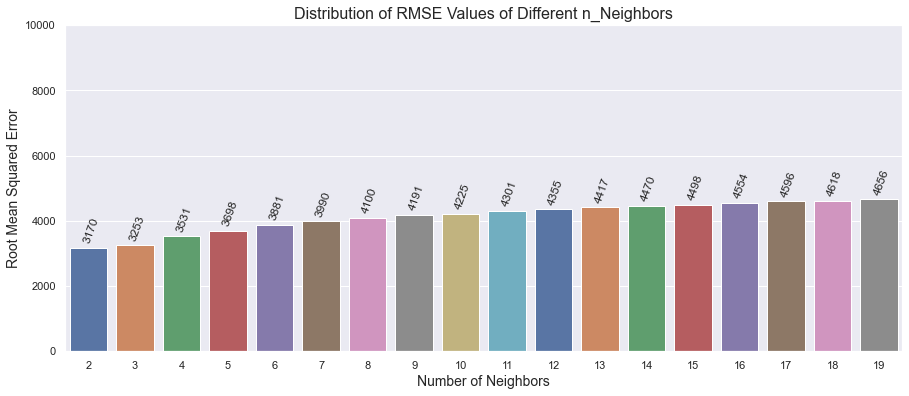

In [108]:
# Set the plot size
plt.figure(figsize=(15,6))

# 
n_neighbors = df['n_neighbors']
rmse_values = df['rmse']

barplot(n_neighbors, rmse_values)
plt.ylim(top=10000)
plt.xticks()
plt.xlabel('Number of Neighbors', fontsize=14)
plt.ylabel('Root Mean Squared Error', fontsize=14)
plt.title('Distribution of RMSE Values of Different n_Neighbors', fontsize=16);

We notice that n_neighbor = 2 has the lowest RMSE value of 3170. We will therefore re-train the model with the value.

In [109]:
# Create a KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=2)

# Fit model, perform prediction and cross validation
knn_R2, knn_RMSE, knn_model = fit_model(knn, data, predictors, printFeatureImportance=False, \
                                        cv_folds=5, alg_name='k_NearestNeighbor')

k_NearestNeighbor R2 score: 75.04%
k_NearestNeighbor RMSE: 3169.88
CV Score: Mean - 5716.00 | Std - 2483.00 | Min - 3239.00 | Max - 9637.00


In [110]:
# Save the Model
save_model(knn_model, 'knn_model.pkl')

Using k=2, we got about 6% improvement in the R2 value, however the RMSE value dropped. So we will explore other models.

## 4.7 -  Decision Trees Regression

DecisionTree R2 score: 84.10%
DecisionTree RMSE: 2530.19
CV Score: Mean - 6046.00 | Std - 2259.00 | Min - 3153.00 | Max - 9652.00


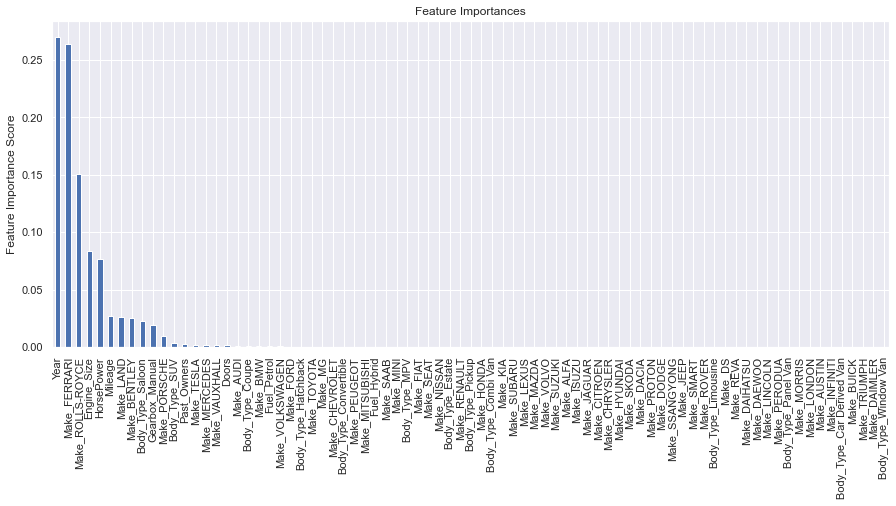

In [111]:
# Instantiate the Decision Tree Regressor
dtree_reg = DecisionTreeRegressor(random_state=42)

# Fit model, perform prediction and cross validation
dtree_R2, dtree_RMSE, dtree_model = fit_model(dtree_reg, data, predictors, cv_folds=5, alg_name='DecisionTree')

In [112]:
# Save the Model
save_model(dtree_model, 'dtree_model.pkl')

We see no improvement in the Decision Tree model compared to the kNN model in terms of the R2 score and RMSE value.

## 4.8 - Random Forest Regression

RandomForestGridSearchCV R2 score: 89.45%
RandomForestGridSearchCV RMSE: 2061.02
CV Score: Mean - 4333.00 | Std - 2579.00 | Min - 1994.00 | Max - 8331.00


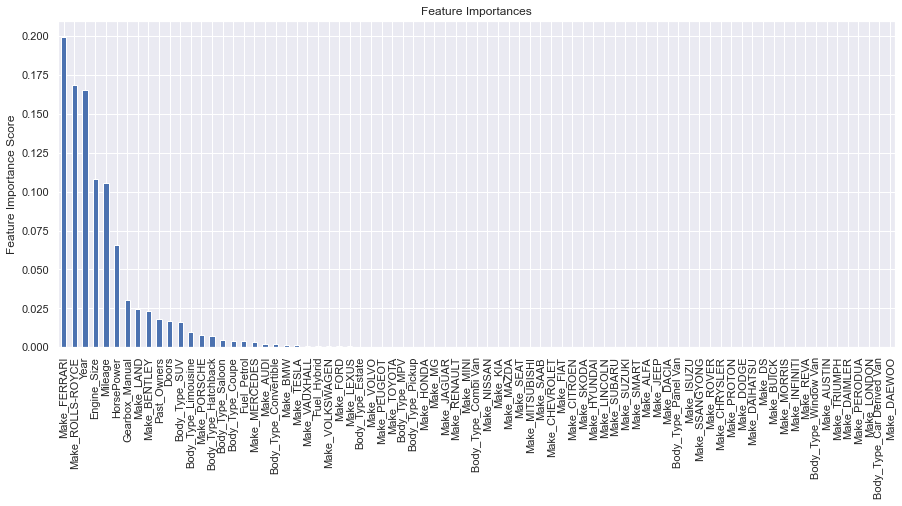

In [113]:
# Instantiate the Decision Tree Regressor
rndforest_reg = RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=900, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

# Fit model, perform prediction and cross validation
rndforest_R2, rndforest_RMSE, rndForest_model = fit_model(rndforest_reg, data, predictors,\
                                                          cv_folds=5, alg_name='RandomForestGridSearchCV')

In [114]:
# Save the Model
save_model(rndForest_model, 'rndForest_model.pkl')

Random Forest model performs slightly better than the Decision Tree model. It achieves this performance by constructing multitude decision trees at training time and outputs the class that is the mode of the classes (classification problem) or mean prediction (regression problem) of the individual trees. Both models can be improved by tuning the hyperparameters.

## 4.9 - XGBoost Model

XGB R2 score: 83.28%
XGB RMSE: 2594.98
CV Score: Mean - 4964.00 | Std - 1689.00 | Min - 2725.00 | Max - 6928.00


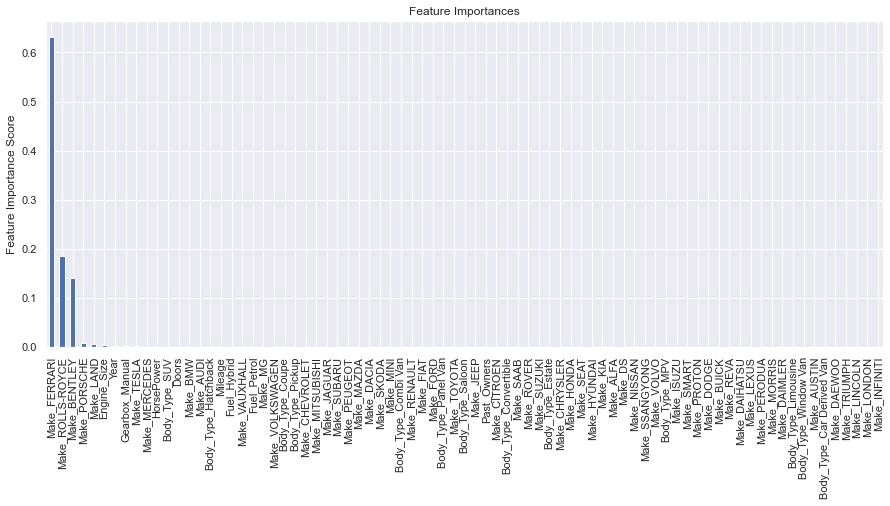

In [115]:
# Instantiate the Extreme Gradient Model
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.1, n_jobs=4)

# Fit model, perform prediction and cross validation
xgb_R2, xgb_RMSE, xgb_model = fit_model(xgb_reg, data, predictors, cv_folds=5, alg_name='XGB')

In [116]:
# Save the Model
save_model(xgb_model, 'xgb_model.pkl')

83% goodness of fit is quite poor for an XGBoost model. However, the model can be improved by fine tuning the hyperparameters.

## 4.10 - Gradient Boosting Regression

[Gradient Boosting](https://statistics.berkeley.edu/sites/default/files/tech-reports/486.pdf) is a machine learning technique for both regression and classification problems. It is a prediciton model in the form of an emsemble (combination of multiple models) of weak prediction models, typically `decision trees`. It works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.


GradientBoosting R2 score: 85.55%
GradientBoosting RMSE: 2412.03
CV Score: Mean - 4263.00 | Std - 2016.00 | Min - 2270.00 | Max - 6845.00


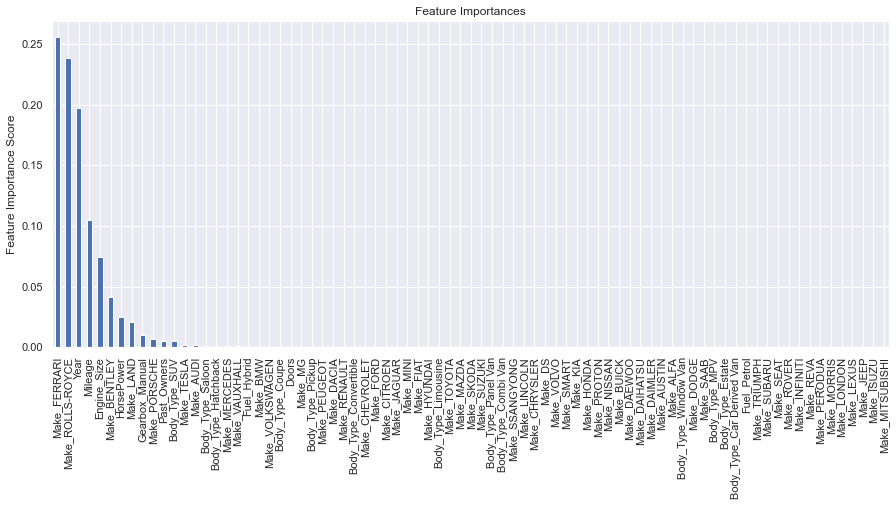

In [117]:
# Instantiate the Gradient Boosting Regressor
GBR = GradientBoostingRegressor(n_estimators=500, 
                                 learning_rate=0.1,
                                 subsample=1,
                                 max_depth=2,
                                 random_state=1)

# Fit model, perform prediction and cross validation
gbr_R2, gbr_RMSE, gbr_model = fit_model(GBR, data, predictors, cv_folds=5, alg_name='GradientBoosting')

In [118]:
# Save the Model
save_model(gbr_model, 'gbr_model.pkl')

## 4.11 - Create a dataframe of the performance metrices

In [119]:
# Create a dataframe of R2 and RMSE values 
r2_scores = pd.DataFrame({
    'LinearRegression' : {'r2_score': lm_R2, 'rmse' : lm_RMSE},
    'kNeighbors' : {'r2_score': knn_R2, 'rmse' : knn_RMSE},
    'DecisionTree' : {'r2_score': dtree_R2, 'rmse' : dtree_RMSE},
    'RandomForest' : {'r2_score': rndforest_R2, 'rmse' : rndforest_RMSE},
    'GradientBoost' : {'r2_score': gbr_R2, 'rmse' : gbr_RMSE},
    'XGB' : {'r2_score': xgb_R2, 'rmse' : xgb_RMSE}
})
r2_scores

,LinearRegression,kNeighbors,DecisionTree,RandomForest,GradientBoost,XGB
r2_score,69.85,75.04,84.10,89.45,85.55,83.28
rmse,3484.39,3169.88,2530.19,2061.02,2412.03,2594.98


#### Comparing Cross Validation mean and standard deviation of the scores of all models

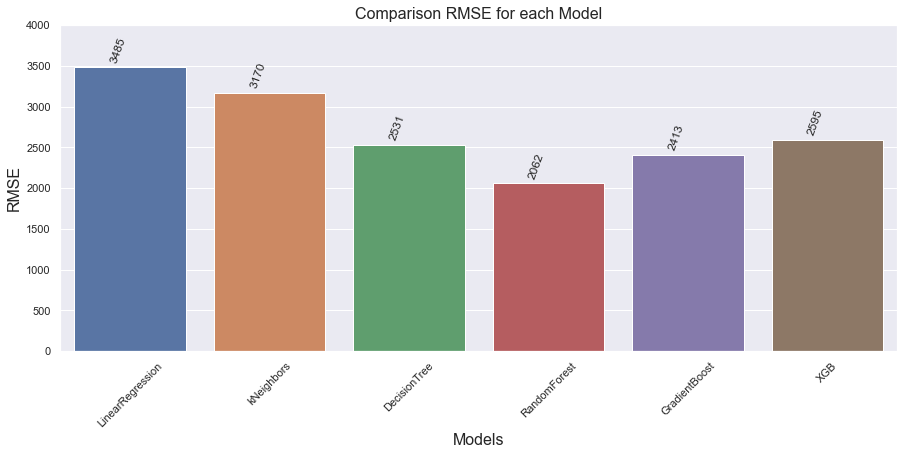

In [120]:
# Plot the RMSE values for each model
alg = r2_scores.columns
rmse_val = r2_scores.loc['rmse']

# Plot the RMSE values for all the models
plot(alg, rmse_val, 45, 4000, 'Comparison RMSE for each Model', 'Models', 'RMSE', 16)

The RandomForest regression model outperforms the other models. This is not to say it is the best model as the hyperparameters for these models are not optimized yet. Further research will be to train the models with tuned hyperparameters using GridSearchCV and/or RandomizedSearchCV, and then compare the results again.

## 4.12 - Defining and Visualizing the Feature Importance
Given that the Random Forest model gives us the best performance of all the models, we will visualize the feature importance, and then select the most appropriate features to build a model with.

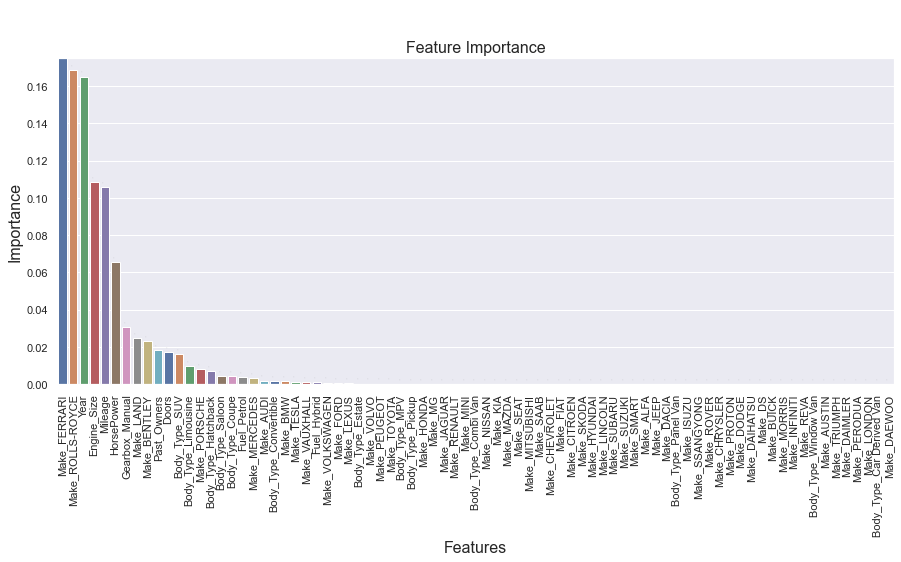

In [121]:
# Get the variables importances, sort them, and print the result
feat_imp = pd.Series(rndForest_model.feature_importances_, predictors).sort_values(ascending=False)

# Visualize the variables importances
plot(feat_imp.index, feat_imp.values, 90, 0.175, 'Feature Importance', 'Features', 'Importance', 16, False)

## Question 3 - Which features influence the price of a car the most?

To answer this questions, let's select the first 20 important features from the best model so far, and analyse their relevance in building the final model. We will then select the final model based the top most importance features.

In [122]:
# List the first 20 important features and sort by the index
feat_imp[:20].sort_values(ascending=False)

Make_FERRARI           0.199612
Make_ROLLS-ROYCE       0.168516
Year                   0.165093
Engine_Size            0.108315
Mileage                0.105867
HorsePower             0.065450
Gearbox_Manual         0.030646
Make_LAND              0.024875
Make_BENTLEY           0.023143
Past_Owners            0.018194
Doors                  0.017118
Body_Type_SUV          0.016038
Body_Type_Limousine    0.009942
Make_PORSCHE           0.008120
Body_Type_Hatchback    0.007019
Body_Type_Saloon       0.004464
Body_Type_Coupe        0.004250
Fuel_Petrol            0.003816
Make_MERCEDES          0.003156
Make_AUDI              0.001996
dtype: float64

This list contains the 6 numerical features registration `Year`, `Mileage`, `Engine size`, `Doors`, `Past Owners` and engine `Horsepower`. The rest are dummy features created from `Make` of the car, `Gearbox` type, `Body` type, and `Fuel` type. From earlier analysis, we saw that number of doors kind of gives an idea of the body type. Also, looking at the first 20 features considered important by the best model (**Random Forest**), we see that the dummy features created from the Make of the car includes the expensive luxury cars with high prices. These are exceptional cases for this particular dataset, and it does not generalize the make of the car as a feature to consider when predicting the price of any car (this is not to say it is not an important feature to consider on other datasets). So we will drop the body type and make of the vehicle. 

For future work, we will investigate the impact of removing these high value cars from the dataset.

We will therefore narrow the number of important features to the following, and re-perform the above process with the best model, and then tune the model.
- Mileage
- Year
- HorsePower
- Engine_Size
- Past_Owners
- Gearbox
- Doors
- Fuel

In [123]:
# List of new categorical features
new_cat_cols = ['Gearbox', 'Fuel']

# New dataframe without body type and vehicle make
auto = auto_cp.drop(labels=['Make', 'Body_Type'], axis=1)

# Create dummy features for the categoricall features
auto = create_dummy_df(auto, new_cat_cols, dummy_na=False)

print(auto.shape)
print(auto.columns)

(8926, 10)
Index(['Doors', 'Year', 'Mileage', 'Engine_Size', 'Past_Owners', 'HorsePower',
       'Prices', 'Gearbox_Manual', 'Fuel_Hybrid', 'Fuel_Petrol'],
      dtype='object')


In [124]:
# Select the features and prices
X = auto.drop('Prices', axis=1)
y = auto.Prices

# Display first five rows of the features
X.head()

,Doors,Year,Mileage,Engine_Size,Past_Owners,HorsePower,Gearbox_Manual,Fuel_Hybrid,Fuel_Petrol
2777,3,2011,81000,1.4,3,16.0000,1,0,1
3020,3,2011,60000,1.4,0,135.0000,1,0,1
24737,3,2015,17240,1.4,2,15.0000,1,0,1
5457,3,2013,51825,1.7,0,96.3883,1,0,1
2357,3,2015,61000,1.4,3,160.0000,1,0,1


In [125]:
# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.20, random_state=42)

print("Size of train dataset: {} rows".format(X_train.shape))
print("Size of test dataset: {} rows".format(X_test.shape))

# learn the scaling parameters (mean & variance) of that dataset
X_train = scaler.fit_transform(X_train)

# scale the testing data using the parameters from the training dataset
X_test = scaler.transform(X_test)

# Save training and test data as list
data = [X_train, y_train, X_test, y_test]

Size of train dataset: (7140, 9) rows
Size of test dataset: (1786, 9) rows


We will fit the best two models to this new dataset, and control the value of max_depth parameter. This represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data (potentially leading to overfitting). We fit each model with depths ranging from 1 to 10 and plot the R2 and RMSE scores.

#### Fitting the Random Forest Model to the new dataset

In [126]:
# Create a list of max_depth values
max_depths = [x for x in range(1,11)]

# List of R2 and RMSE scores
r2 = []
rmse = []

# For loop to try 10 different values of max depth
for max_depth in max_depths:
    # Instantiate the Random Forest Regressor
    rn_forest = RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=max_depth, max_features=9, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

    # Fit model and perform prediction
    rn_forest_R2, rn_forest_RMSE, rn_forest_model = fit_model(rn_forest, data, predictors, performCV=False,\
                                                              printFeatureImportance=False, printScore=False, cv_folds=5,\
                                                              alg_name='RandomForestGridSearchCV')
    # Append R2 and RMSE scores
    r2.append(rn_forest_R2)
    rmse.append(rn_forest_RMSE)

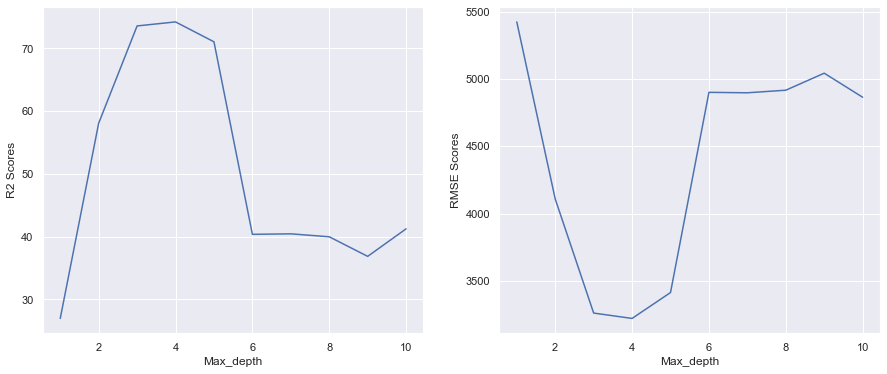

In [127]:
# Set the plot size
plt.figure(figsize = (15, 6))

# Plot of Max_depth vs R2
plt.subplot(1,2,1)
sns.lineplot(max_depths, r2)
plt.xlabel("Max_depth")
plt.ylabel('R2 Scores')

# Plot of Max_depth vs RMSE
plt.subplot(1,2,2)
sns.lineplot(max_depths, rmse)
plt.xlabel("Max_depth")
plt.ylabel('RMSE Scores');

The RandomForest model gets an R2 score of about 75% with max_depth equal to 4. This isn't a good enough score.

#### Fitting the Gradient Boosting Model to the new dataset

In [128]:
# List of R2 and RMSE scores
r2 = []
rmse = []

# For loop to try 10 different values of max depth
for max_depth in max_depths:
    # Instantiate the Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(n_estimators=800, 
                                 learning_rate=0.055,
                                 subsample=1,
                                 max_depth=max_depth,
                                 random_state=1)
    
    # Fit model and perform prediction
    gbr_R2, gbr_RMSE, gbr_model = fit_model(gbr, data, predictors, performCV=False,\
                                            printFeatureImportance=False, printScore=False, \
                                            cv_folds=5, alg_name='GradientBoosting')
    # Append R2 and RMSE scores
    r2.append(gbr_R2)
    rmse.append(gbr_RMSE)

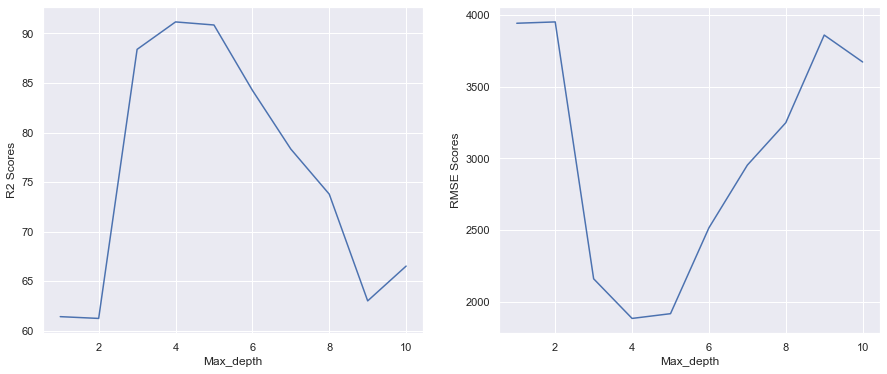

In [129]:
# Set the plot size
plt.figure(figsize = (15, 6))

# Plot of Max_depth vs R2
plt.subplot(1,2,1)
sns.lineplot(max_depths, r2)
plt.xlabel("Max_depth")
plt.ylabel('R2 Scores')

# Plot of Max_depth vs RMSE
plt.subplot(1,2,2)
sns.lineplot(max_depths, rmse)
plt.xlabel("Max_depth")
plt.ylabel('RMSE Scores');

For the new dataset, GradientBoosting gives a better result - R2 score over 90% with max_depth of 4. Therefore we will use this parameter for our best model.

GradientBoosting R2 score: 91.16%
GradientBoosting RMSE: 1886.70
CV Score: Mean - 6028.00 | Std - 2545.00 | Min - 2606.00 | Max - 9570.00


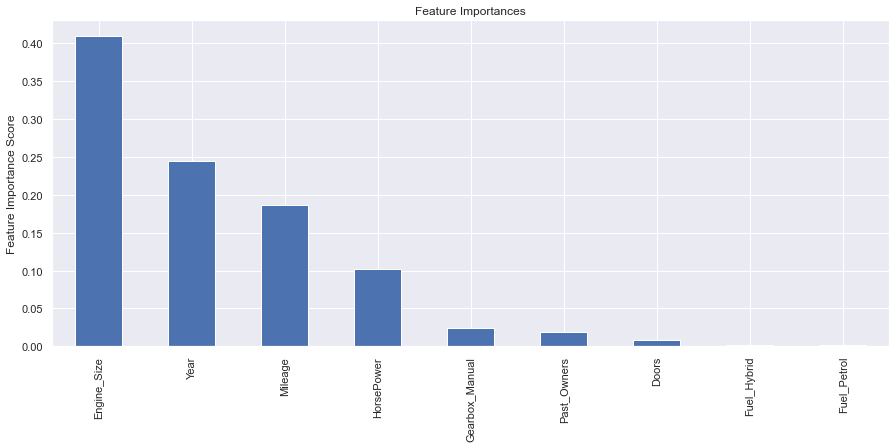

In [130]:
# Select the training features
predictors = X.columns

# Instantiate the Gradient Boosting Regressor with the tuned hyperparameters
best_model = GradientBoostingRegressor(n_estimators=800, 
                             learning_rate=0.055,
                             subsample=1,
                             max_depth=4,
                             random_state=1)

# Fit model, perform prediction and cross validation
gbr_R2_best, gbr_RMSE_best, gbr_model_best = fit_model(best_model, data, predictors, cv_folds=5, alg_name='GradientBoosting')

In [131]:
save_model(gbr_model_best, 'best_model.pkl')

#### Comparing all models 

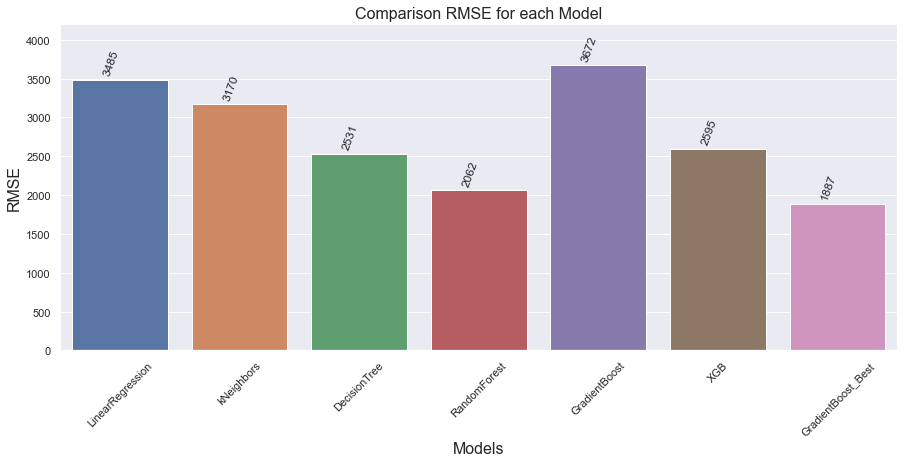

In [132]:
# Create a dataframe of R2 and RMSE values 
r2_scores = pd.DataFrame({
    'LinearRegression' : {'r2_score': lm_R2, 'rmse' : lm_RMSE},
    'kNeighbors' : {'r2_score': knn_R2, 'rmse' : knn_RMSE},
    'DecisionTree' : {'r2_score': dtree_R2, 'rmse' : dtree_RMSE},
    'RandomForest' : {'r2_score': rndforest_R2, 'rmse' : rndforest_RMSE},
    'GradientBoost' : {'r2_score': gbr_R2, 'rmse' : gbr_RMSE},
    'XGB' : {'r2_score': xgb_R2, 'rmse' : xgb_RMSE},
    'GradientBoost_Best' : {'r2_score': gbr_R2_best, 'rmse' : gbr_RMSE_best}
})

# Plot the RMSE values for each model
alg = r2_scores.columns
rmse_val = r2_scores.loc['rmse']

# Plot the RMSE values for all the models
plot(alg, rmse_val, 45, 4200, 'Comparison RMSE for each Model', 'Models', 'RMSE', 16)

From the above analysis, we can conclude that the most important features in predicting the price of a car, based on our dataset are as follows
- Engine size
- Year of car registration, i.e. the age of the car
- Mileage completed at the point of sale
- Engine Horsepower
- Engine transmission type
- Number of past owners
- Number of doors
- Fuel type

# PART 5 - Results & Summary

In this project, we looked at the problem of predicting car sales based on certain features of the vehicle. The data was obtained by scraping AutoTrader - 38 post codes at 100 pages per post codes, which resulted in 70,656 rows of data comprising of 11 features and 1 target (car prices). 

Duplicates were dropped, and the resulting dataset was cleaned and processed, leading to a final dataset with 8926 rows.

Linear Regression, k-Nearest Neighbors, Decision Trees, Random Forest, Gradient Boosting and XGboost models were used for the prediction of car prices, and k-fold cross validation used to assess the predictive performance of the models. The results were pretty impressive - Gradient Boosting performed best out of all other models, having the lowest root mean squared error (RMSE) of £1886.7, and an R2 score of 91.16%.

Eight features were identified as most influential in predicting the price of a car, based on the gven dataset. This isn't to say these are the only important features that determine the price of the vehicle. The more features (and rows) we have in the dataset, the more acturate the the model is. More effort will be put in to gather more data and to search for the optimal parameters for the Gradient Boosting Regression model using GridSearchCV, RandomizedSearchCV, etc and will be the focus of future research on this project after deployment.

Next step will be model deployment, to allow users predict the price of their vehicles based on selected vehicle features.